## Libraries

In [2]:
from optbinning import OptimalBinning
from loan_data.preprocess_functions import preprocess
from init_char_analysis import *
import numpy as np
import glob
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn import linear_model, metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

(CVXPY) Nov 23 02:39:30 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Nov 23 02:39:30 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


## Read in csv's

In [3]:
path = "../../dataset/"
files = glob.glob(path + "/*.csv") 
processed_df = []
for file in files:
    if file == "../../dataset/2019_stat.csv":
        continue 
    print(file)
    temp_data = pd.read_csv(file)
    processed_df.append(temp_data)
    del temp_data
processed_df = pd.concat(processed_df)

../../dataset/2023_stat.csv
../../dataset/2022_stat.csv
../../dataset/2020_stat.csv
../../dataset/2021_stat.csv


In [4]:
processed_df.columns

Index(['LOAN_ID', 'ORIG_RATE', 'ORIG_AMOUNT', 'ORIG_TERM', 'OLTV', 'NUM_BO',
       'DTI', 'CSCORE_B', 'CSCORE_C', 'FTHB_FLAG', 'PUR_Cash_out',
       'PUR_Refinance', 'PUR_Purchase', 'PRO_Condominium', 'PRO_Co_operative',
       'PRO_Planned_Urban', 'PRO_Manufact_Home', 'PRO_Single_Family',
       'NUM_UNIT', 'OCC_Principal', 'OCC_Second', 'OCC_Investor', 'STATE',
       'ZIP', 'MSA', 'MI_PCT', 'MI_Borrower', 'MI_Lender', 'MI_Investor',
       'AQSN_DTE', 'ORIG_DTE', 'FRST_DTE', 'LAST_RATE', 'LAST_UPB',
       'LAST_ACTIVITY_DATE', 'DLQ_30_FLAG', 'DLQ_60_FLAG', 'DLQ_90_FLAG',
       'DLQ_120_FLAG', 'Ongoing', 'Current_DLQ', 'Prepaid_Matured',
       'Third_Party_Sale', 'Short_Sale', 'Repurchased', 'Deed_In_Lieu',
       'Non_Performing_NS', 'Reperforming_NS', 'COMPLETE_FLAG', 'NET_LOSS',
       'NET_SEV'],
      dtype='object')

# Undo one-hot encoding & filter relevant columns

In [5]:
ONE_HOT_ENCODED_MAP = {
    "PUR": ['PUR_Cash_out','PUR_Refinance', 'PUR_Purchase'],
    "PRO": ['PRO_Condominium', 'PRO_Co_operative','PRO_Planned_Urban', 'PRO_Manufact_Home', 'PRO_Single_Family'],
    "MI": ['MI_Borrower', 'MI_Lender', 'MI_Investor'],
    "OCC": ['OCC_Principal', 'OCC_Second', 'OCC_Investor']
}

for new_col, cols in ONE_HOT_ENCODED_MAP.items():
    indices = processed_df[cols].to_numpy().argmax(axis=1)
    categories = [col.split('_', 1)[1] for col in cols]  # Extract category names
    processed_df[new_col] = np.array(categories)[indices] 
    processed_df.drop(columns=cols, inplace=True)

processed_df

,LOAN_ID,ORIG_RATE,ORIG_AMOUNT,ORIG_TERM,OLTV,NUM_BO,DTI,CSCORE_B,CSCORE_C,FTHB_FLAG,...,Deed_In_Lieu,Non_Performing_NS,Reperforming_NS,COMPLETE_FLAG,NET_LOSS,NET_SEV,PUR,PRO,MI,OCC
0,135176712,6.50,206000.0,360,60.0,1,36.0,797.0,797.0,0,...,0,0,0,0.0,0.0,0.0,Purchase,Planned_Urban,Borrower,Investor
1,135176713,6.38,162000.0,360,50.0,1,41.0,746.0,746.0,0,...,0,0,0,0.0,0.0,0.0,Cash_out,Single_Family,Borrower,Principal
2,135176714,7.62,206000.0,360,75.0,2,26.0,799.0,806.0,0,...,0,0,0,0.0,0.0,0.0,Purchase,Planned_Urban,Borrower,Investor
3,135176715,6.75,361000.0,360,85.0,1,48.0,788.0,788.0,1,...,0,0,0,0.0,0.0,0.0,Purchase,Single_Family,Borrower,Principal
4,135176716,7.00,350000.0,360,50.0,2,37.0,619.0,671.0,0,...,0,0,0,0.0,0.0,0.0,Purchase,Single_Family,Borrower,Principal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4782087,129937967,2.50,160000.0,360,62.0,1,17.0,803.0,803.0,0,...,0,0,0,0.0,0.0,0.0,Refinance,Single_Family,Borrower,Principal
4782088,129937968,2.99,450000.0,360,90.0,1,36.0,740.0,740.0,1,...,0,0,0,0.0,0.0,0.0,Purchase,Condominium,Borrower,Principal
4782089,129937969,2.50,153000.0,180,70.0,2,31.0,770.0,724.0,0,...,0,0,0,0.0,0.0,0.0,Cash_out,Single_Family,Borrower,Principal
4782090,129937970,2.50,250000.0,180,51.0,2,40.0,755.0,711.0,0,...,0,0,0,0.0,0.0,0.0,Cash_out,Planned_Urban,Borrower,Principal


In [6]:
processed_df.columns

Index(['LOAN_ID', 'ORIG_RATE', 'ORIG_AMOUNT', 'ORIG_TERM', 'OLTV', 'NUM_BO',
       'DTI', 'CSCORE_B', 'CSCORE_C', 'FTHB_FLAG', 'NUM_UNIT', 'STATE', 'ZIP',
       'MSA', 'MI_PCT', 'AQSN_DTE', 'ORIG_DTE', 'FRST_DTE', 'LAST_RATE',
       'LAST_UPB', 'LAST_ACTIVITY_DATE', 'DLQ_30_FLAG', 'DLQ_60_FLAG',
       'DLQ_90_FLAG', 'DLQ_120_FLAG', 'Ongoing', 'Current_DLQ',
       'Prepaid_Matured', 'Third_Party_Sale', 'Short_Sale', 'Repurchased',
       'Deed_In_Lieu', 'Non_Performing_NS', 'Reperforming_NS', 'COMPLETE_FLAG',
       'NET_LOSS', 'NET_SEV', 'PUR', 'PRO', 'MI', 'OCC'],
      dtype='object')

In [8]:
processed_df = processed_df[(processed_df['DLQ_90_FLAG'] == 1) | (processed_df['DLQ_90_FLAG'] == 0) & (processed_df['Ongoing'] == 1)]

RELEVANT_COLUMNS = [
    'ORIG_RATE', 'ORIG_AMOUNT', 'ORIG_TERM', 'OLTV', 'NUM_BO',
    'DTI', 'CSCORE_B', 'CSCORE_C', 'FTHB_FLAG', 'NUM_UNIT', 'MI_PCT', 
    'DLQ_90_FLAG', 'PUR', 'PRO', 'MI', 'OCC'
]
processed_df = processed_df[RELEVANT_COLUMNS]

## WOE on Categorical Variables

In [ ]:
CAT_COLUMNS = [
    'PUR',
    'PRO',
    'OCC',
    'MI',
    'FTHB_FLAG'  # not sure if this should be here
]

PURPOSE


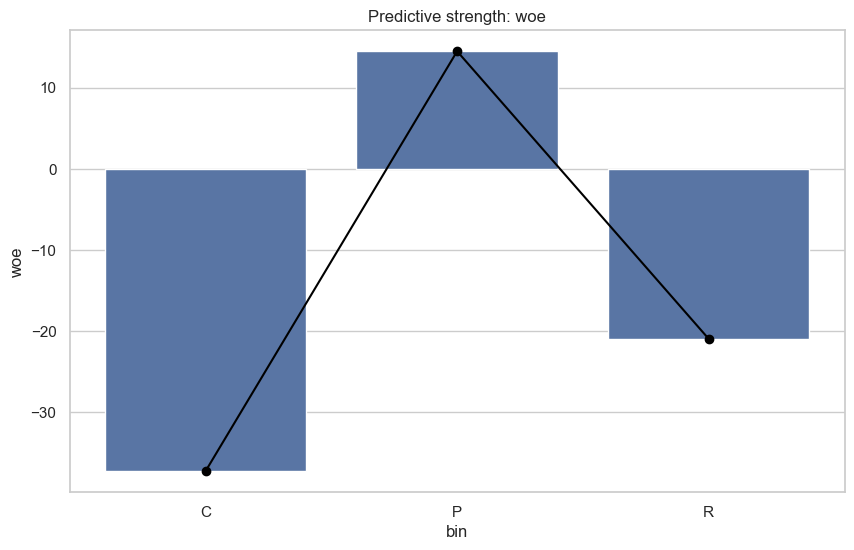

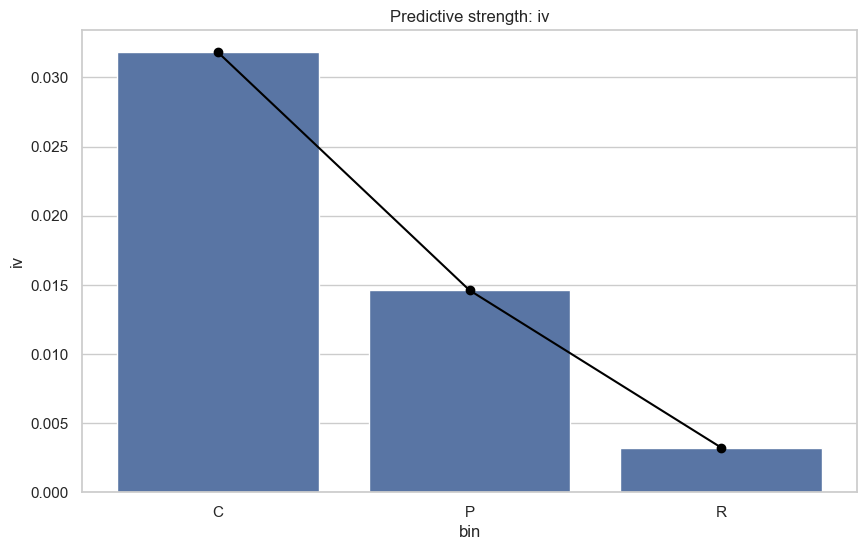

iv=0.0496666035446385
           woe        iv
bin                     
C   -37.313864  0.031824
P    14.510467  0.014610
R   -20.984642  0.003232


PROP_TYPE


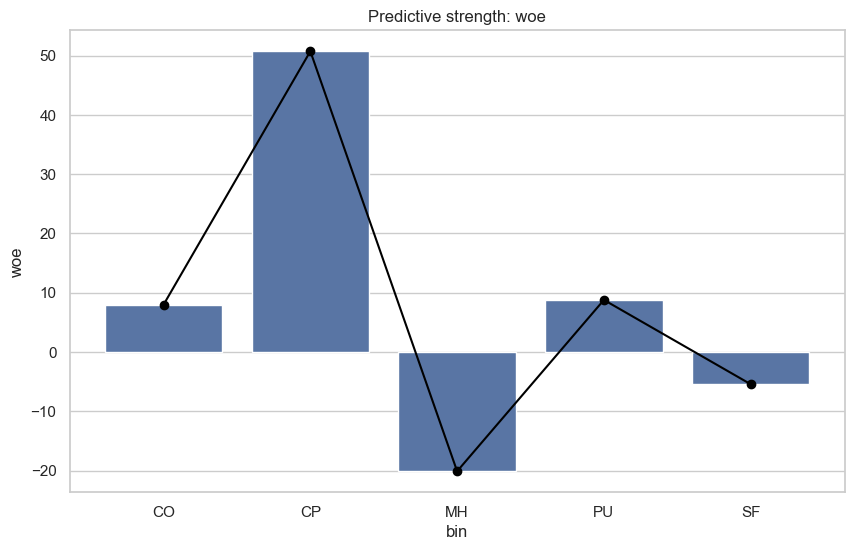

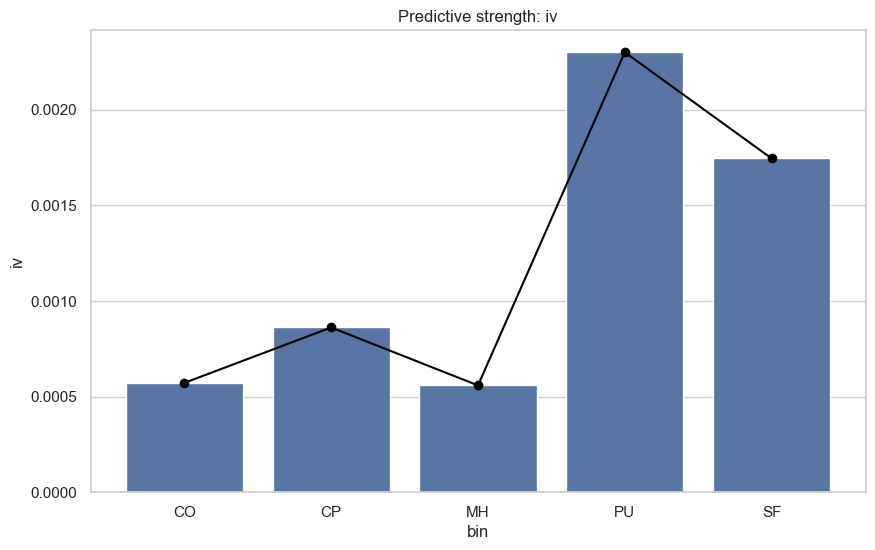

iv=0.00603956645764402
           woe        iv
bin                     
CO    7.995109  0.000572
CP   50.723179  0.000862
MH  -20.089372  0.000559
PU    8.794778  0.002301
SF   -5.415467  0.001746


OCC_STAT


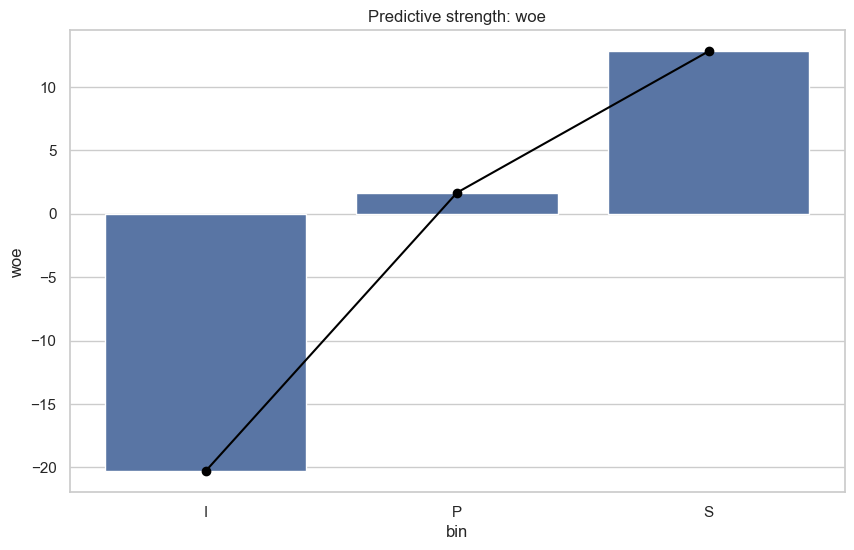

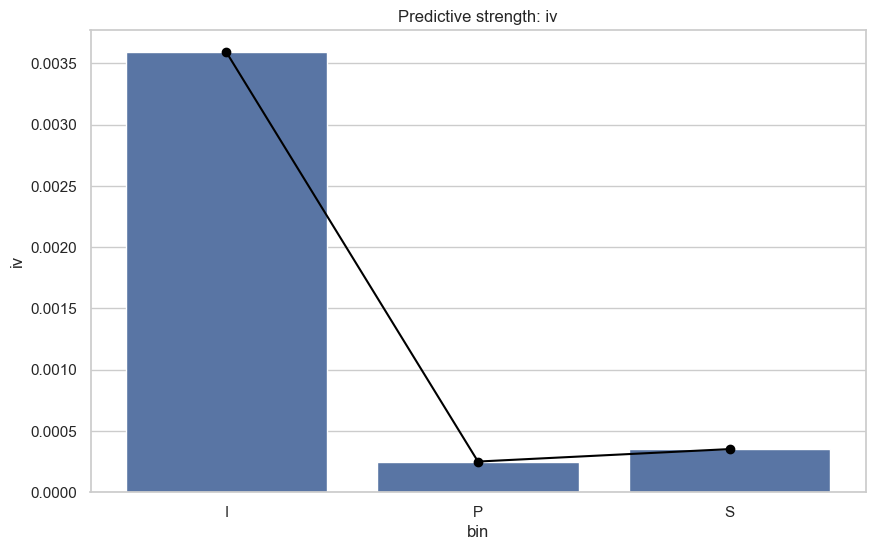

iv=0.004192697044523538
           woe        iv
bin                     
I   -20.296409  0.003590
P     1.676663  0.000250
S    12.819261  0.000352


MI_TYPE


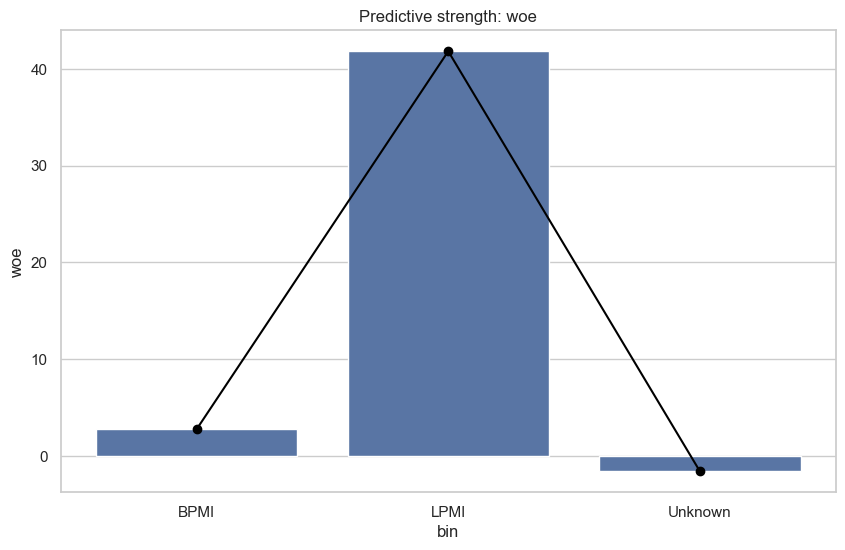

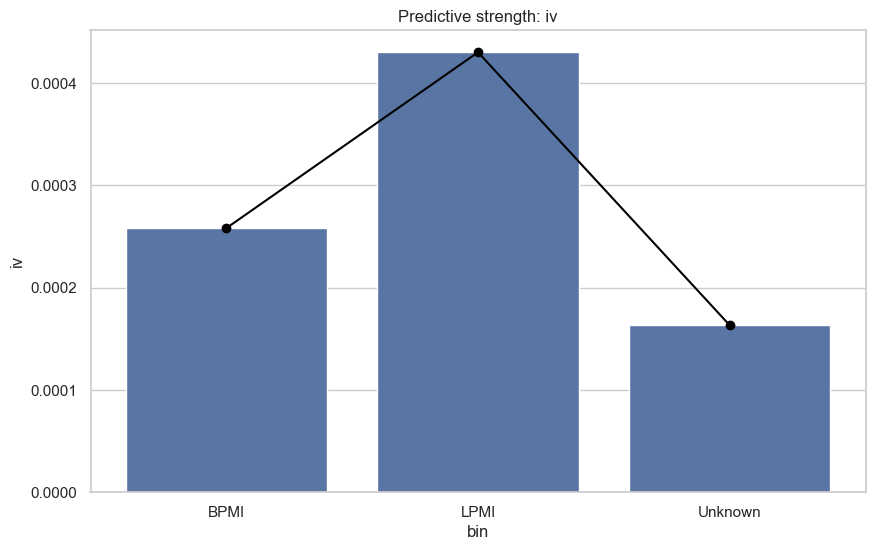

iv=0.0008519434821728216
               woe        iv
bin                         
BPMI      2.762781  0.000258
LPMI     41.817134  0.000430
Unknown  -1.574518  0.000163


FTHB_FLAG


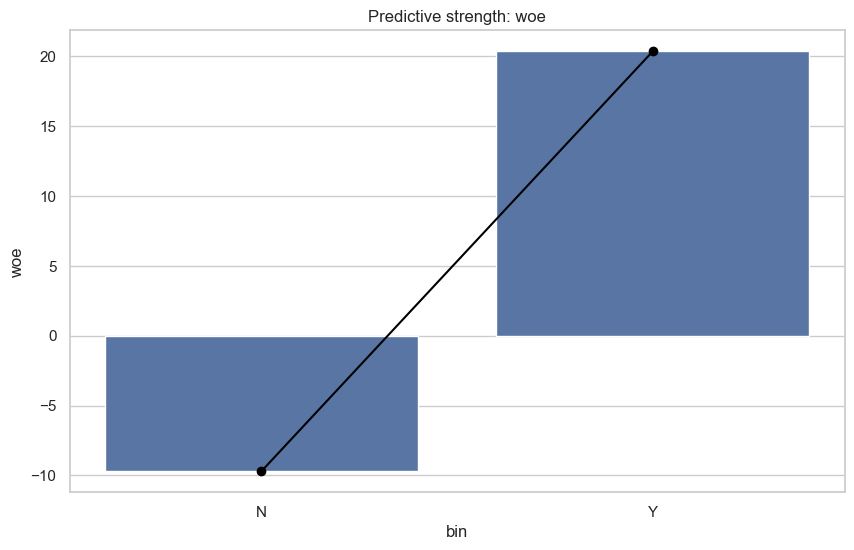

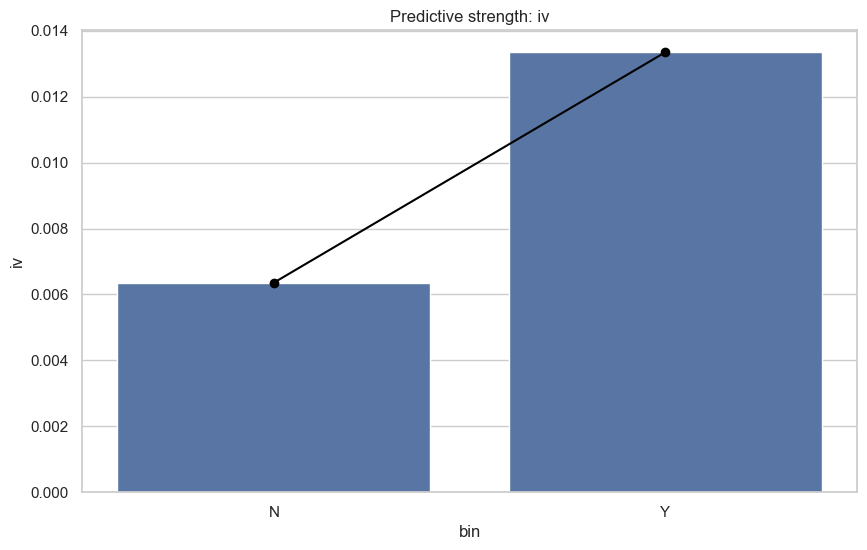

iv=0.01970452352049691
           woe        iv
bin                     
N    -9.696602  0.006358
Y    20.354466  0.013346




In [4]:
for col in CAT_COLUMNS:
    processed_df[col] =processed_df[col].fillna("Unknown")
    print(col)
    results, iv = get_measures(
        orig_data=processed_df,
        grouped_data=processed_df.groupby(col)
    )
    print(f'{iv=}')
    print(results)
    print("===========================\n\n")

## Numerical variables

In [5]:
NUMERICAL_COLUMNS = [
    "ORIG_RATE",
    "ORIG_AMOUNT",	
    "ORIG_TERM",
    "OCLTV",
    "NUM_BO", 
    "DTI",
    "CSCORE_B", 
    "CSCORE_C",
    "NUM_UNIT"]


### Experimental Implementation

ORIG_RATE
Bin either does not contain any 'bad' or 'good' observations.


/var/folders/js/zv14t_p906xd0p0p9fq7clrw0000gn/T/ipykernel_3471/2876108159.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data=num_df.groupby('bins')


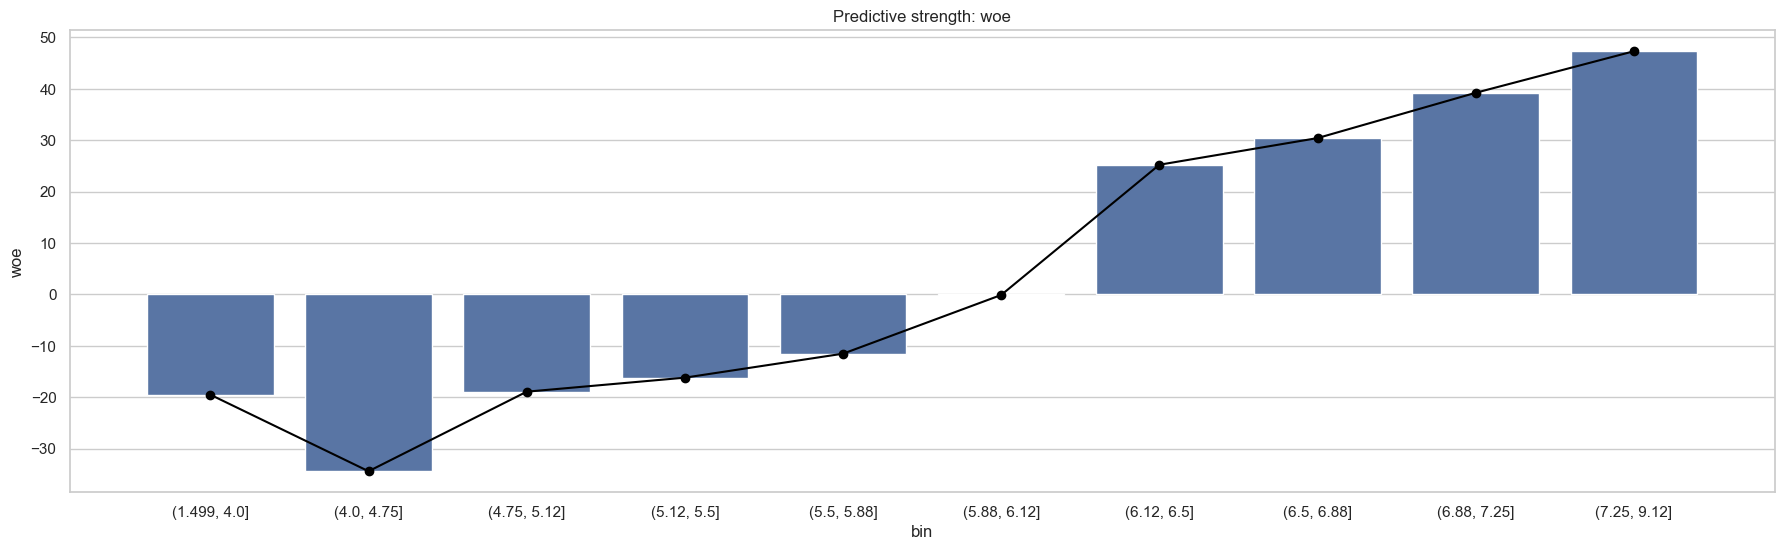

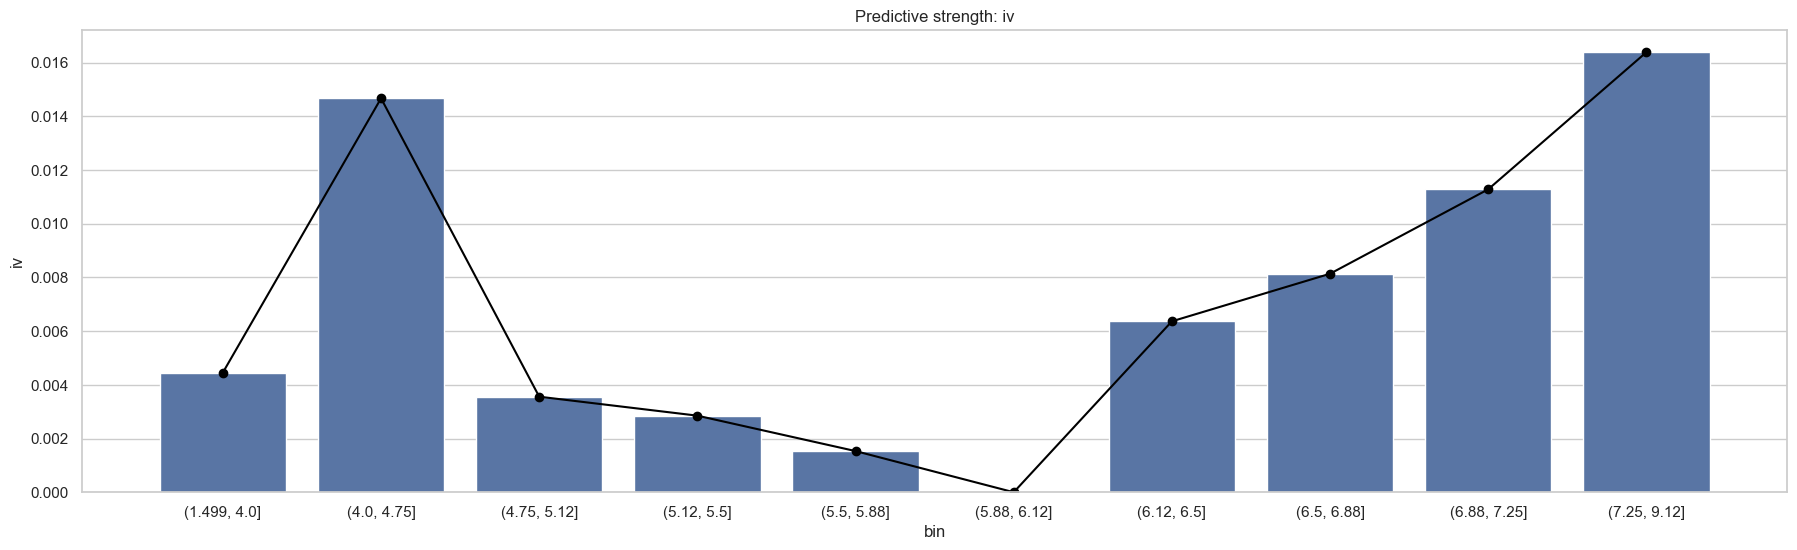

iv=0.06926124068311532
                    woe            iv
bin                                  
(1.499, 4.0] -19.507998  4.459741e-03
(4.0, 4.75]  -34.397079  1.467463e-02
(4.75, 5.12] -18.916622  3.559604e-03
(5.12, 5.5]  -16.188481  2.852886e-03
(5.5, 5.88]  -11.521415  1.533615e-03
(5.88, 6.12]  -0.100894  9.650312e-08
(6.12, 6.5]   25.238061  6.366727e-03
(6.5, 6.88]   30.425562  8.139440e-03
(6.88, 7.25]  39.241370  1.128420e-02
(7.25, 9.12]  47.321698  1.639030e-02
Unknown             NaN           NaN


ORIG_AMOUNT
Bin either does not contain any 'bad' or 'good' observations.


/var/folders/js/zv14t_p906xd0p0p9fq7clrw0000gn/T/ipykernel_3471/2876108159.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data=num_df.groupby('bins')


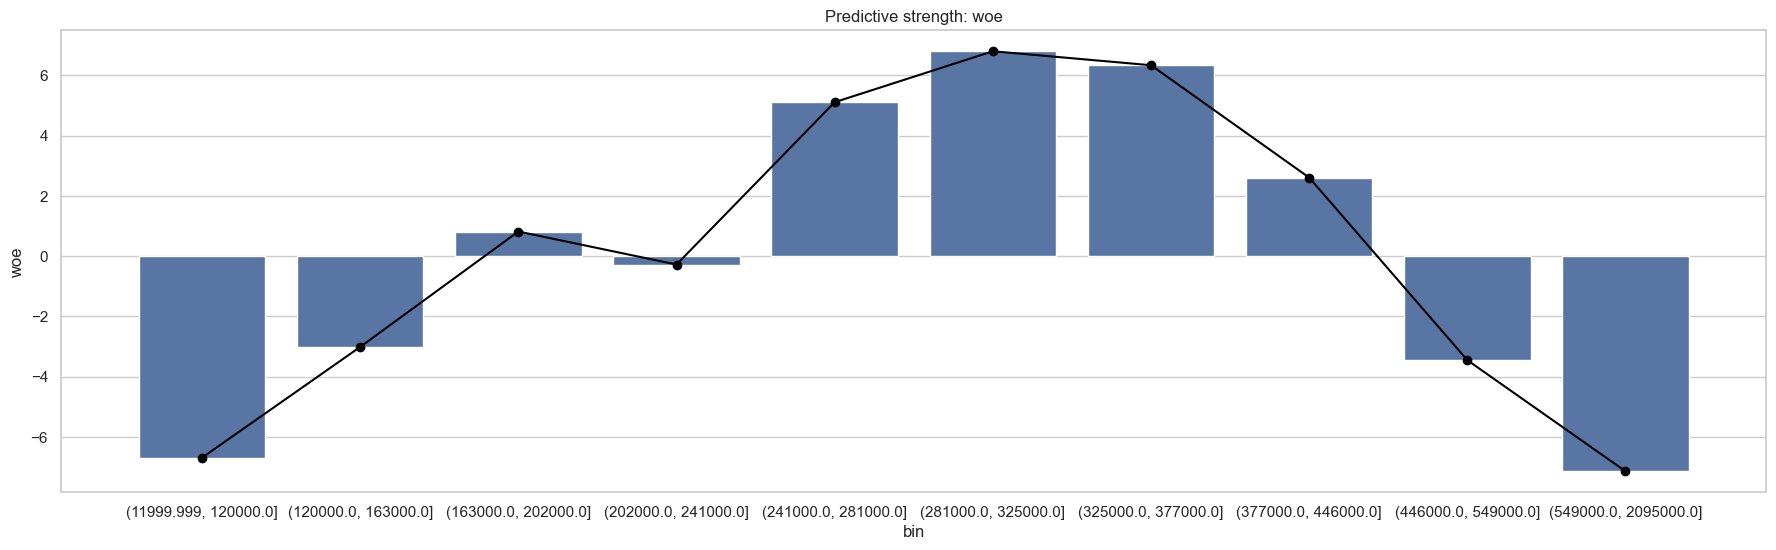

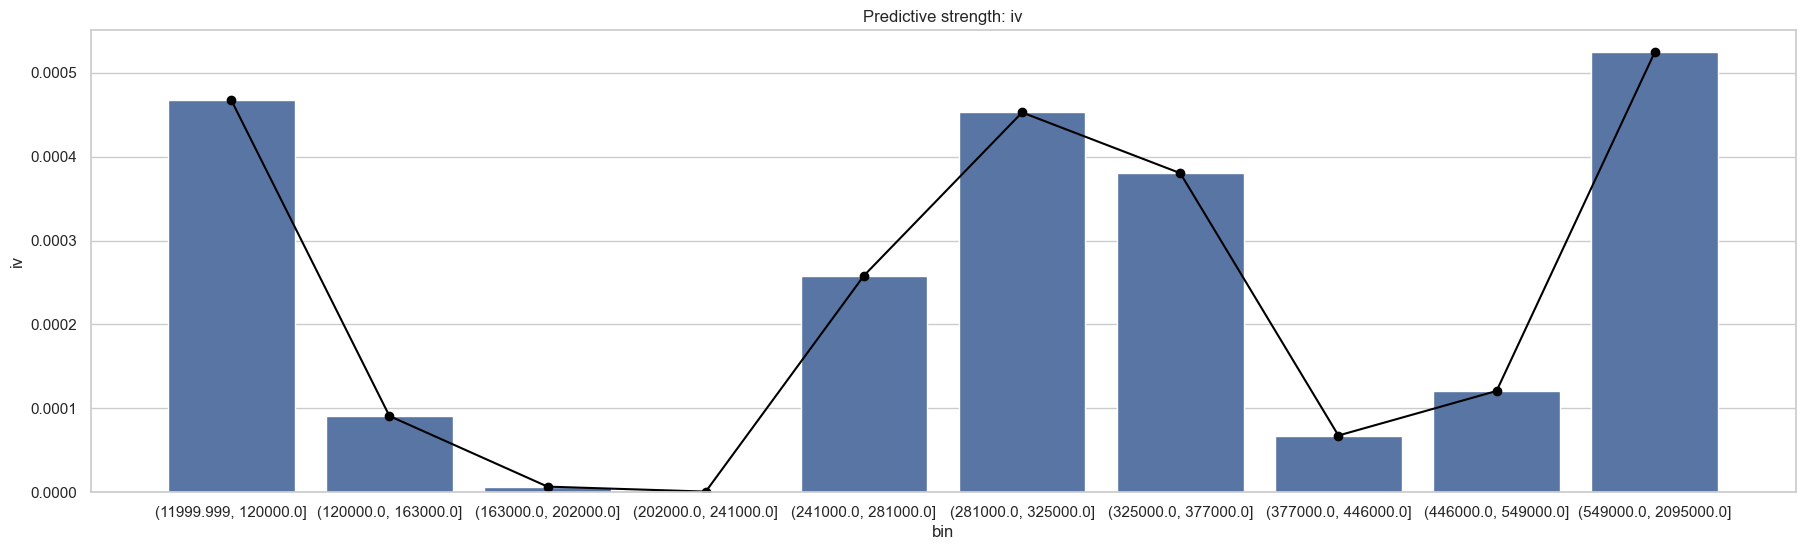

iv=0.002369431877887038
                            woe            iv
bin                                          
(11999.999, 120000.0] -6.690484  4.673390e-04
(120000.0, 163000.0]  -3.013870  9.087120e-05
(163000.0, 202000.0]   0.816914  6.692042e-06
(202000.0, 241000.0]  -0.278898  7.787319e-07
(241000.0, 281000.0]   5.109578  2.581233e-04
(281000.0, 325000.0]   6.801160  4.526225e-04
(325000.0, 377000.0]   6.336881  3.803019e-04
(377000.0, 446000.0]   2.607967  6.761166e-05
(446000.0, 549000.0]  -3.452344  1.207123e-04
(549000.0, 2095000.0] -7.140293  5.243793e-04
Unknown                     NaN           NaN


ORIG_TERM
Bin either does not contain any 'bad' or 'good' observations.


/var/folders/js/zv14t_p906xd0p0p9fq7clrw0000gn/T/ipykernel_3471/2876108159.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data=num_df.groupby('bins')


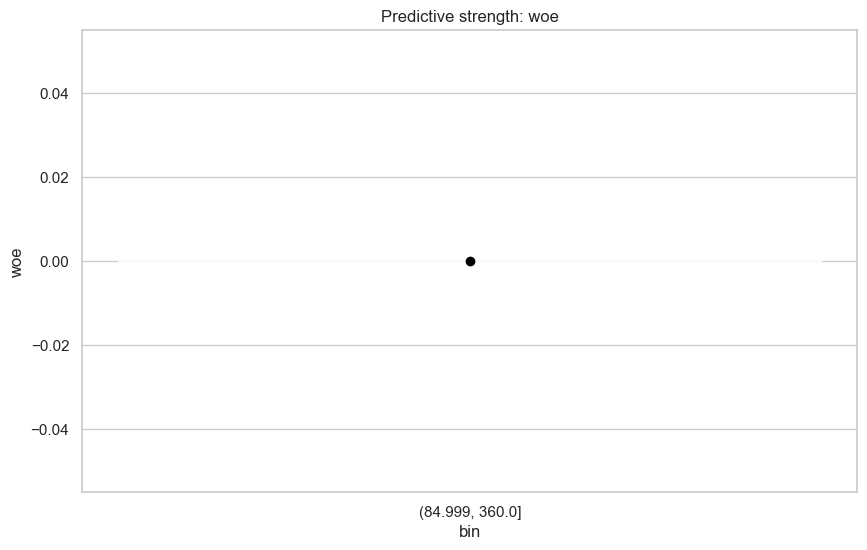

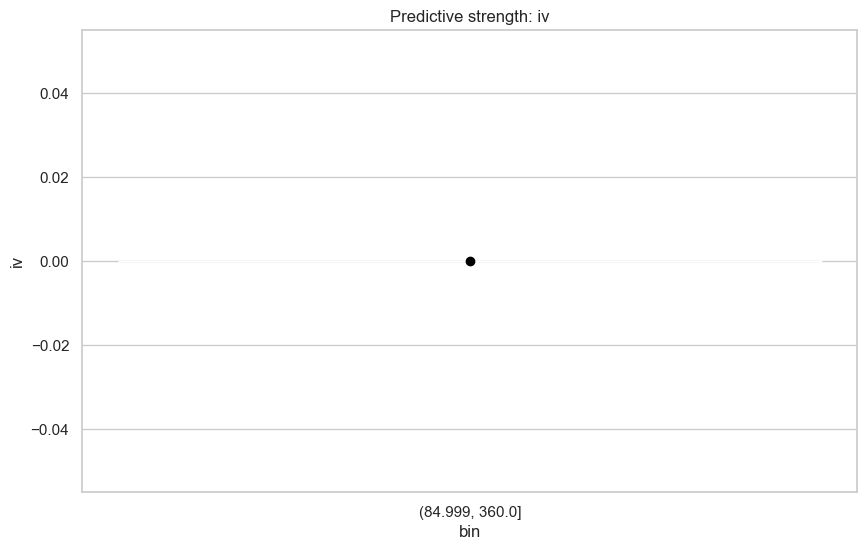

iv=0.0
                 woe   iv
bin                      
(84.999, 360.0]  0.0  0.0
Unknown          NaN  NaN


OCLTV
Bin either does not contain any 'bad' or 'good' observations.


/var/folders/js/zv14t_p906xd0p0p9fq7clrw0000gn/T/ipykernel_3471/2876108159.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data=num_df.groupby('bins')


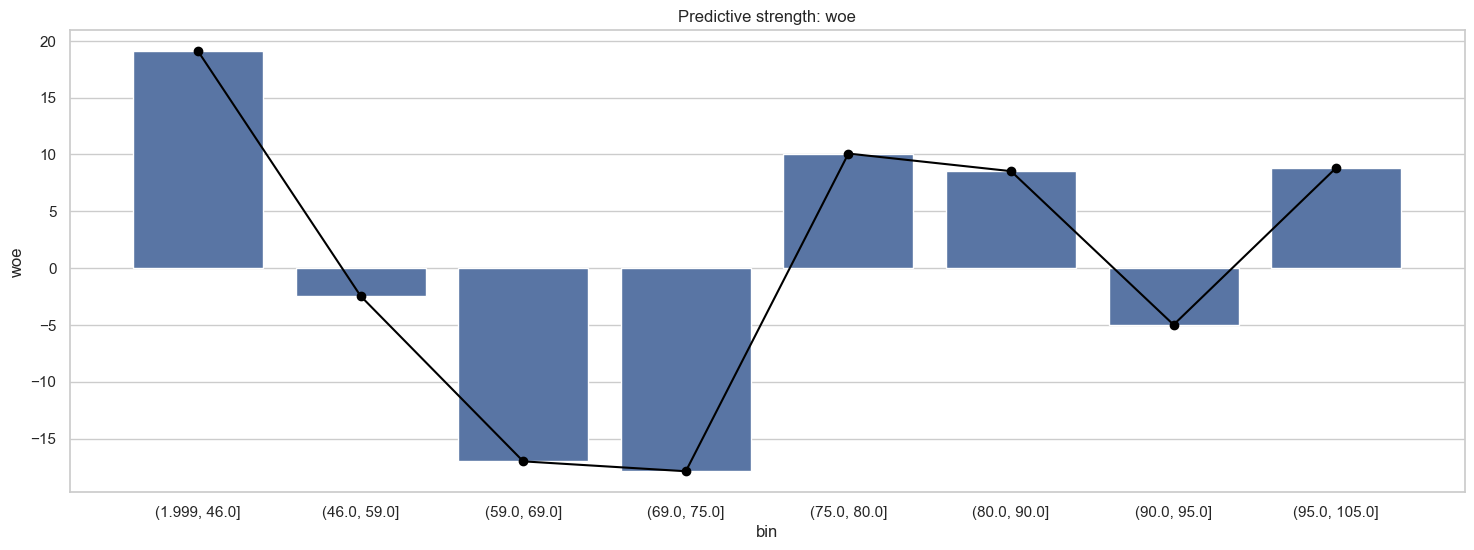

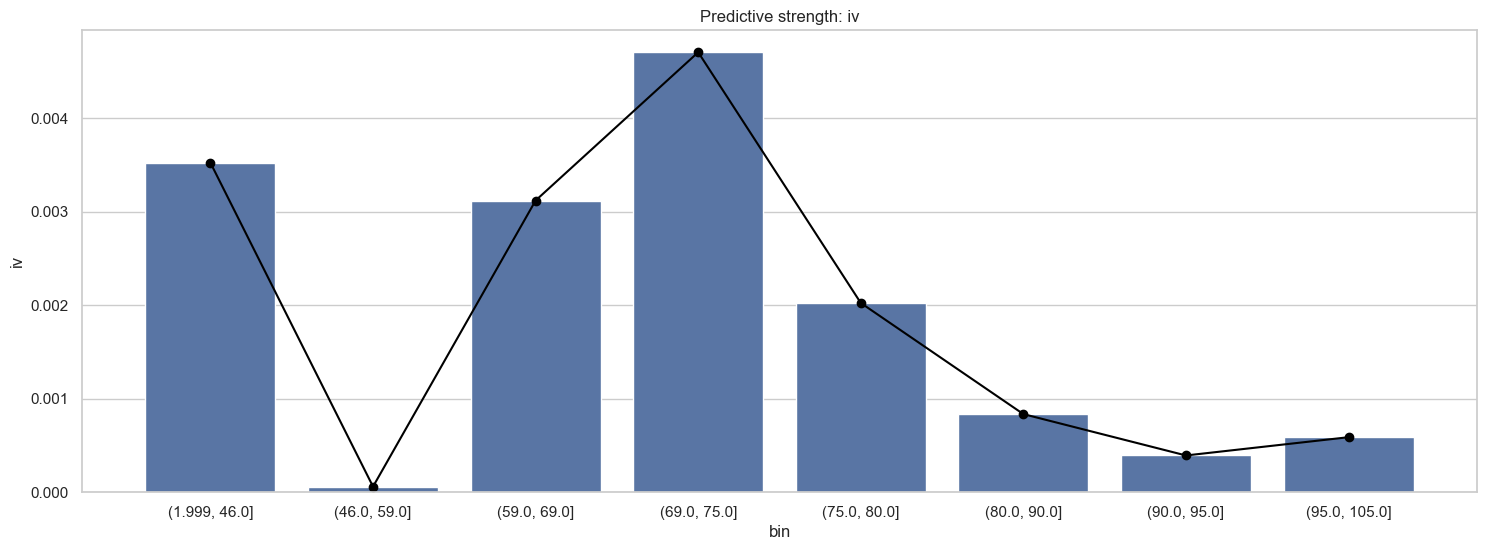

iv=0.015244424317080221
                     woe        iv
bin                               
(1.999, 46.0]  19.086271  0.003522
(46.0, 59.0]   -2.461388  0.000060
(59.0, 69.0]  -17.009454  0.003119
(69.0, 75.0]  -17.880308  0.004703
(75.0, 80.0]   10.080845  0.002023
(80.0, 90.0]    8.532486  0.000835
(90.0, 95.0]   -4.985001  0.000393
(95.0, 105.0]   8.829472  0.000588
Unknown              NaN       NaN


NUM_BO
Bin either does not contain any 'bad' or 'good' observations.


/var/folders/js/zv14t_p906xd0p0p9fq7clrw0000gn/T/ipykernel_3471/2876108159.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data=num_df.groupby('bins')


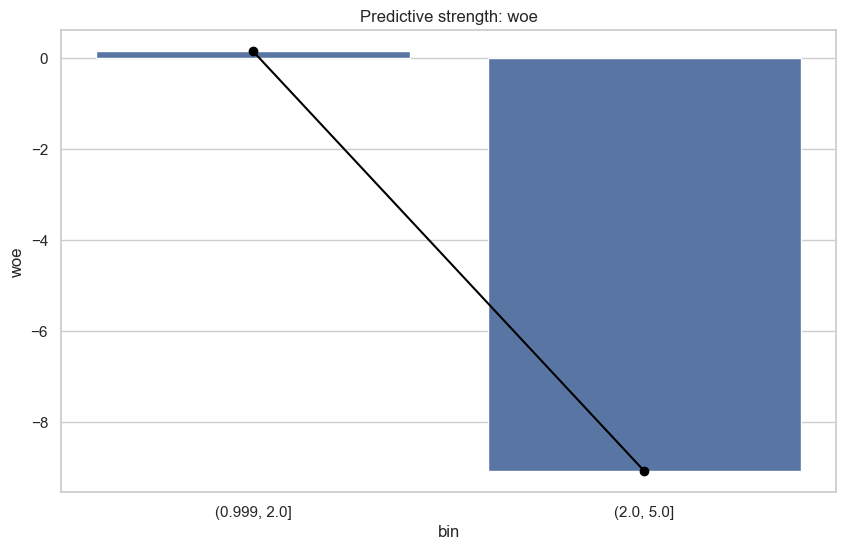

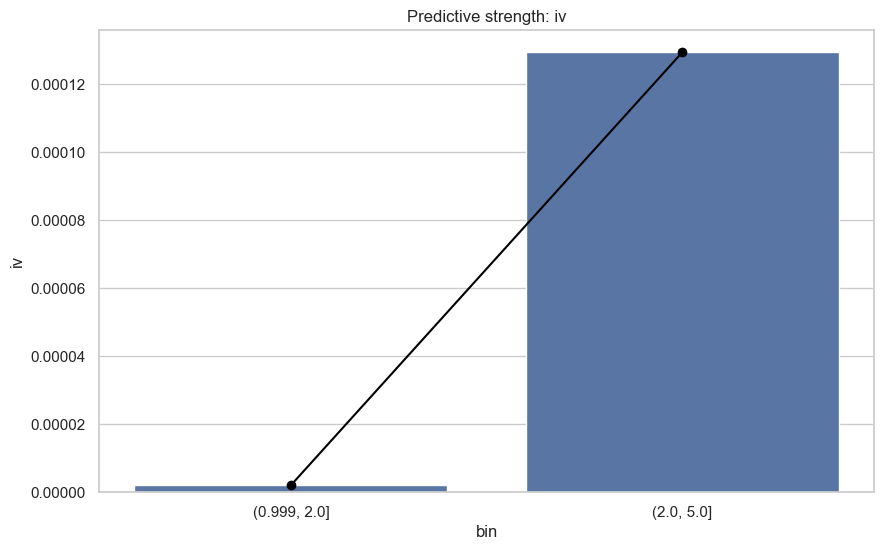

iv=0.0001314178756121708
                   woe        iv
bin                             
(0.999, 2.0]  0.144766  0.000002
(2.0, 5.0]   -9.078037  0.000129
Unknown            NaN       NaN


DTI


/var/folders/js/zv14t_p906xd0p0p9fq7clrw0000gn/T/ipykernel_3471/2876108159.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data=num_df.groupby('bins')


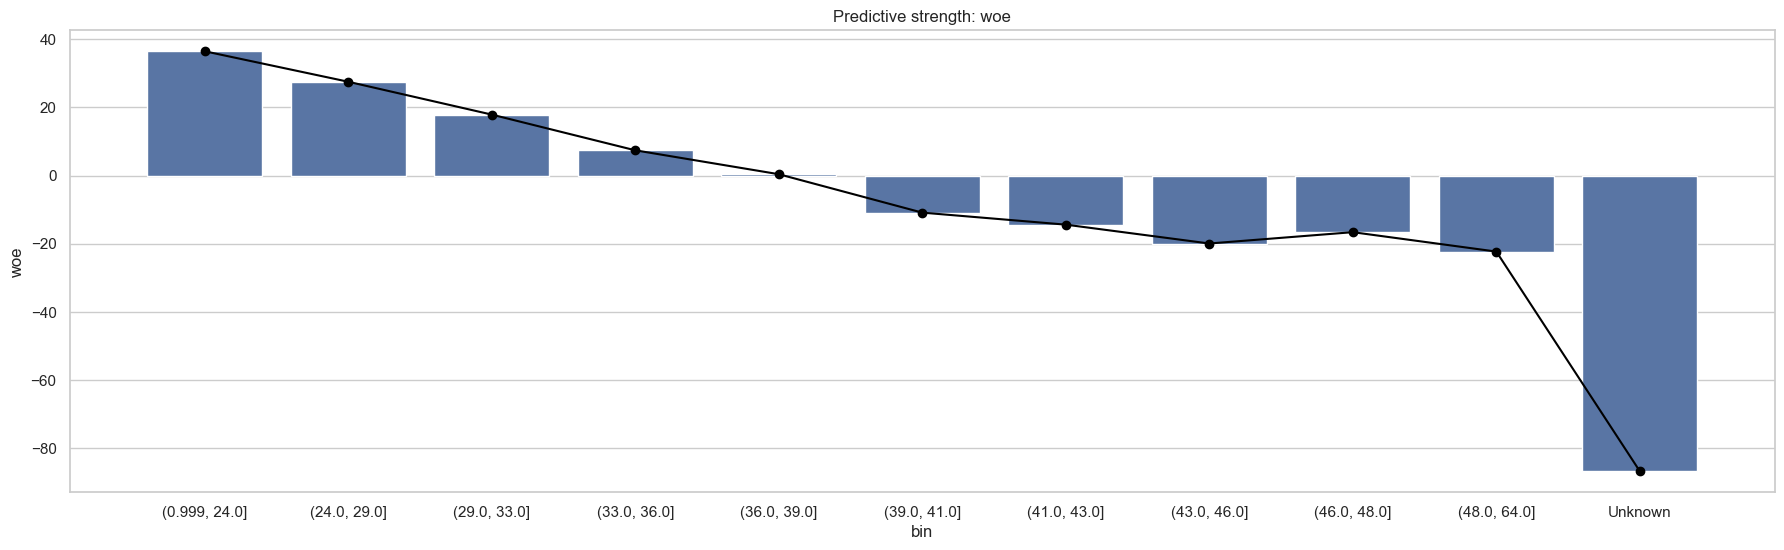

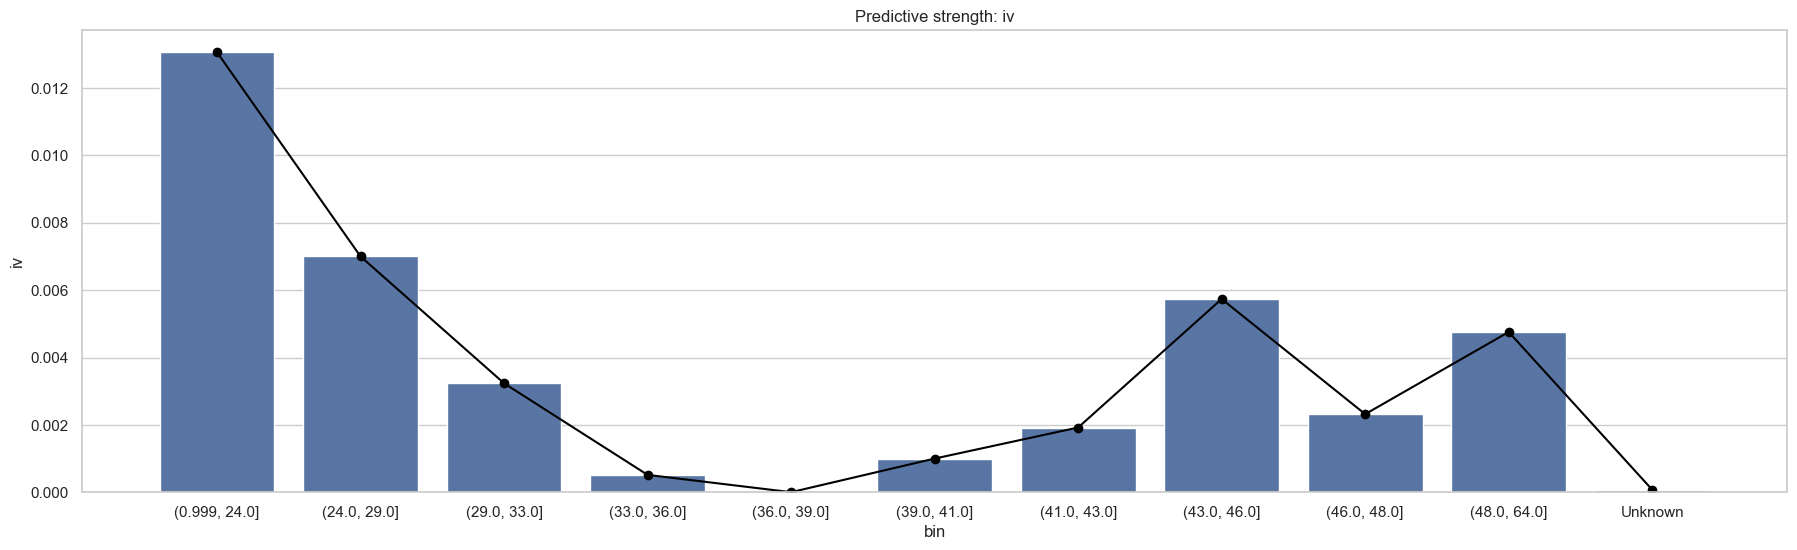

iv=0.03962863505493972
                     woe        iv
bin                               
(0.999, 24.0]  36.470900  0.013064
(24.0, 29.0]   27.528191  0.007001
(29.0, 33.0]   17.890956  0.003235
(33.0, 36.0]    7.415118  0.000516
(36.0, 39.0]    0.402648  0.000002
(39.0, 41.0]  -10.869420  0.001000
(41.0, 43.0]  -14.396771  0.001922
(43.0, 46.0]  -19.928107  0.005737
(46.0, 48.0]  -16.604770  0.002319
(48.0, 64.0]  -22.300539  0.004759
Unknown       -86.740049  0.000074


CSCORE_B


/var/folders/js/zv14t_p906xd0p0p9fq7clrw0000gn/T/ipykernel_3471/2876108159.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data=num_df.groupby('bins')


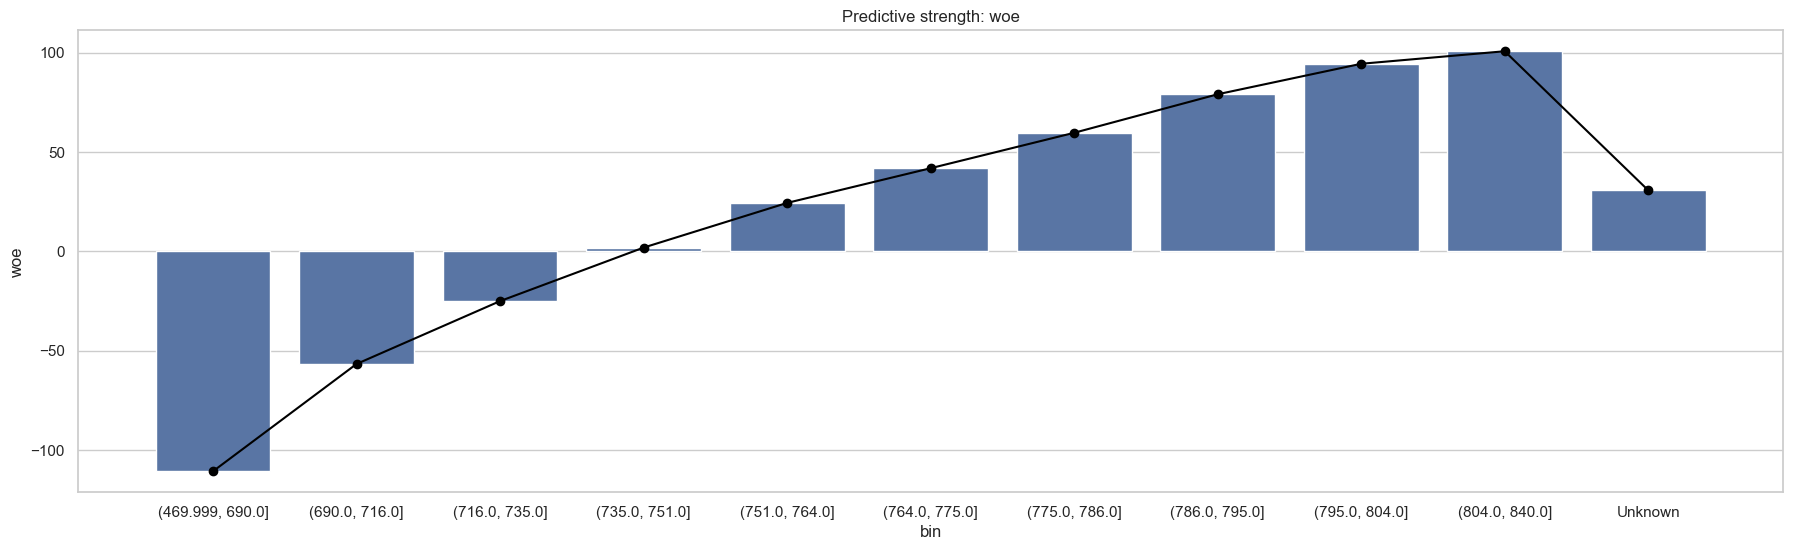

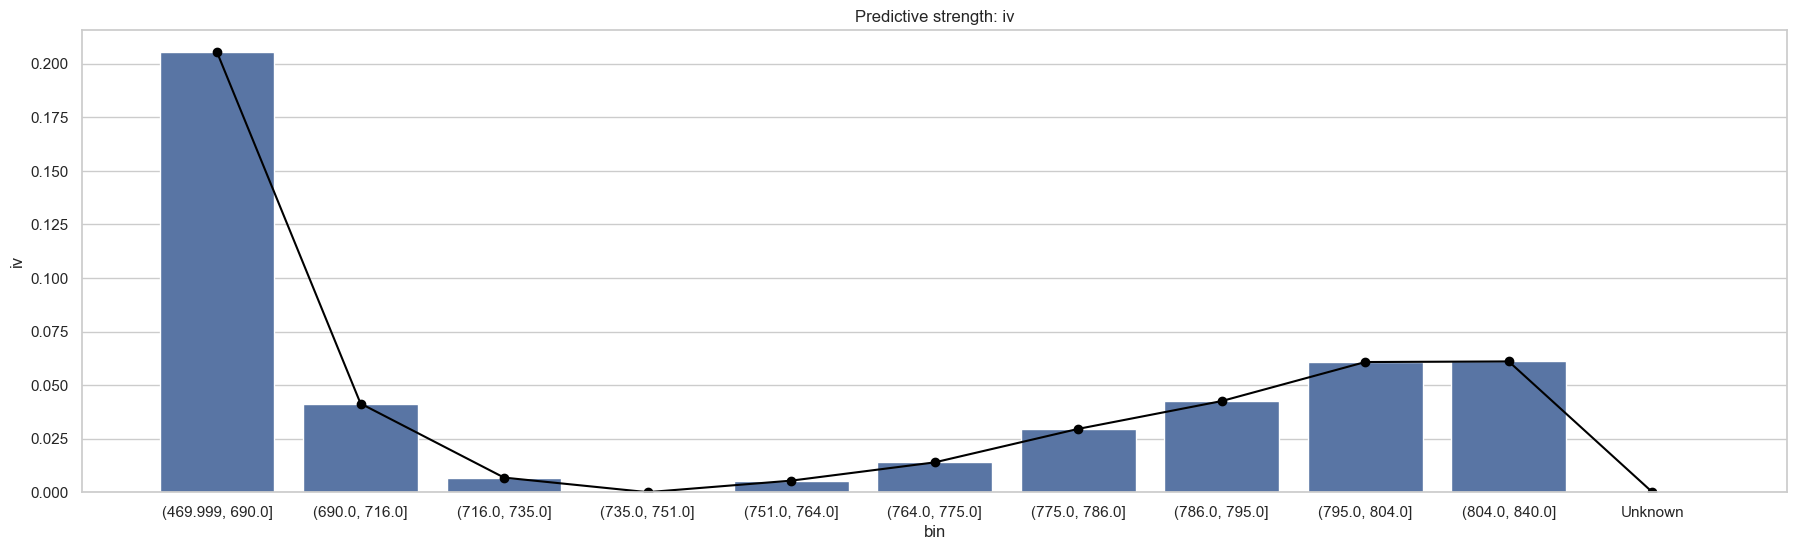

iv=0.46716262287917387
                         woe        iv
bin                                   
(469.999, 690.0] -110.582160  0.205406
(690.0, 716.0]    -56.612713  0.041416
(716.0, 735.0]    -24.985572  0.006840
(735.0, 751.0]      1.928806  0.000039
(751.0, 764.0]     24.406722  0.005411
(764.0, 775.0]     41.860102  0.013943
(775.0, 786.0]     59.673452  0.029579
(786.0, 795.0]     79.058704  0.042563
(795.0, 804.0]     94.394061  0.060783
(804.0, 840.0]    100.697983  0.061075
Unknown            30.752159  0.000109


CSCORE_C


/var/folders/js/zv14t_p906xd0p0p9fq7clrw0000gn/T/ipykernel_3471/2876108159.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data=num_df.groupby('bins')


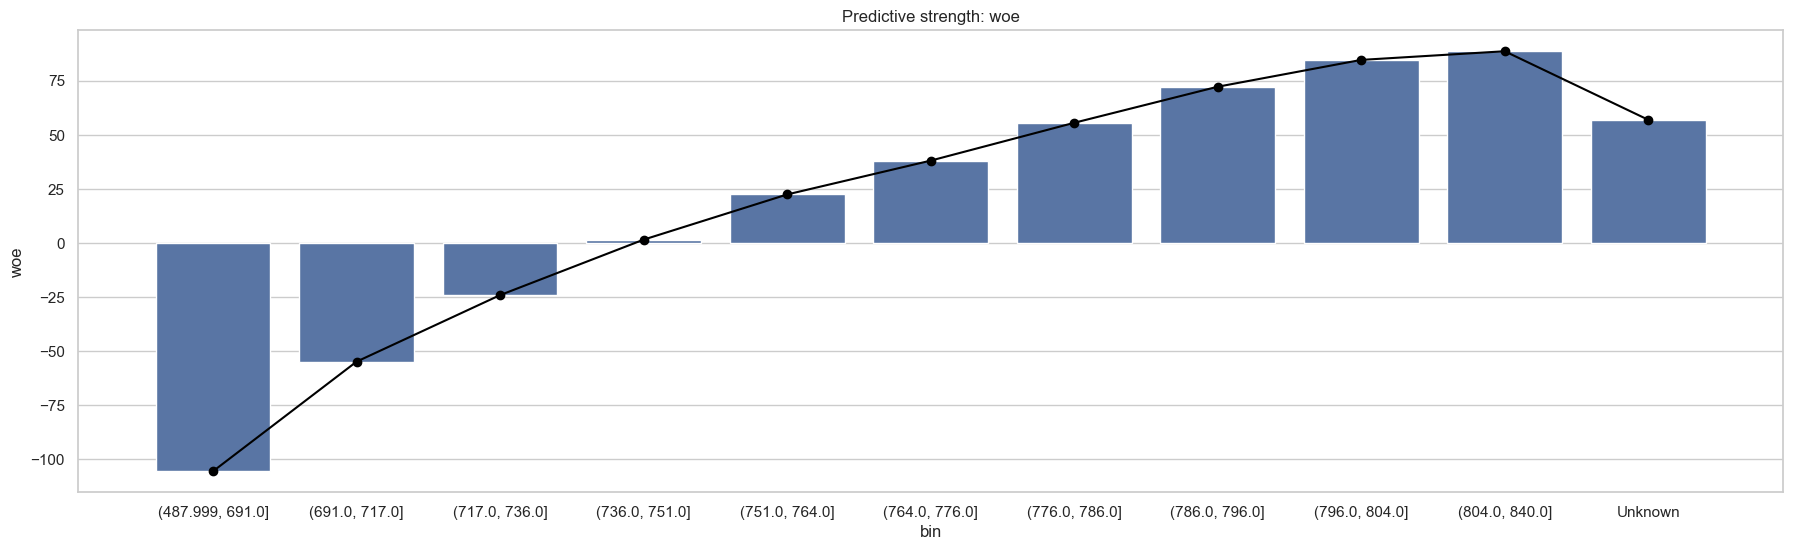

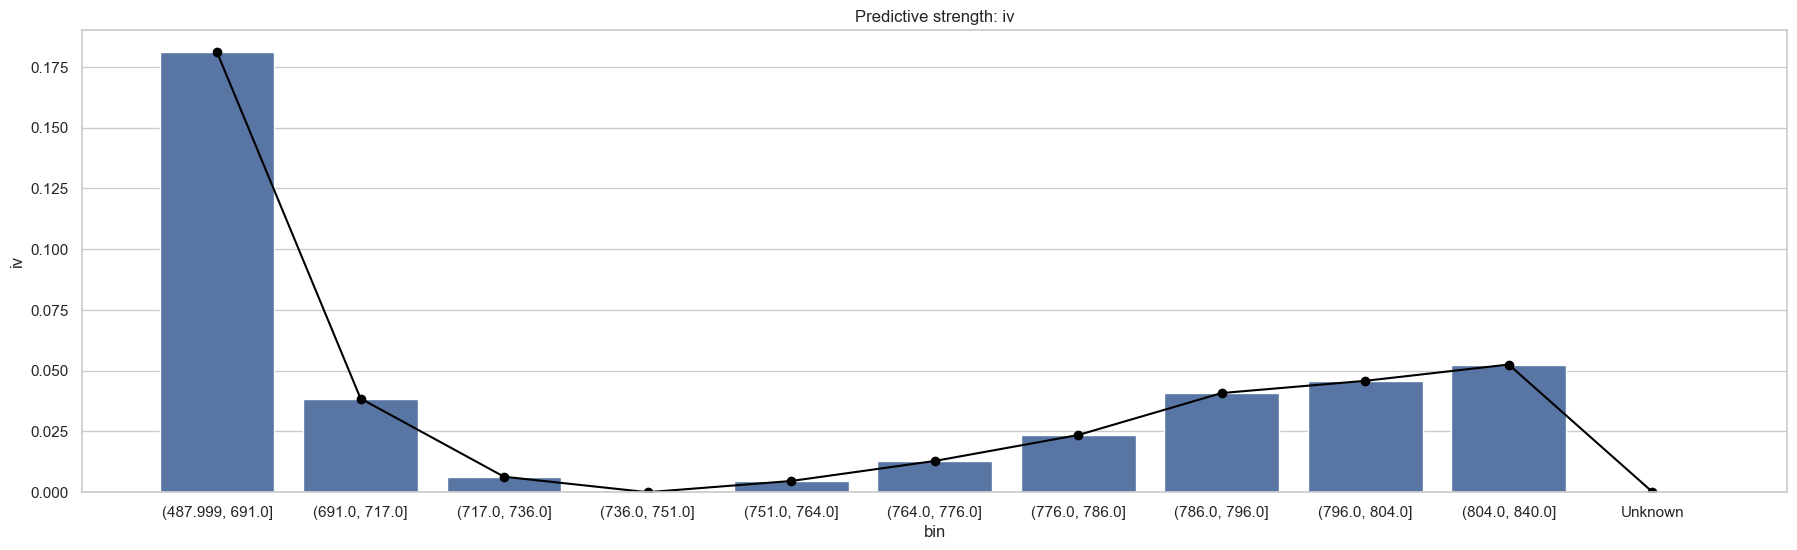

iv=0.40647517267684813
                         woe        iv
bin                                   
(487.999, 691.0] -105.459675  0.181056
(691.0, 717.0]    -54.813289  0.038571
(717.0, 736.0]    -24.057631  0.006380
(736.0, 751.0]      1.575822  0.000025
(751.0, 764.0]     22.458600  0.004625
(764.0, 776.0]     38.094467  0.012865
(776.0, 786.0]     55.575253  0.023540
(786.0, 796.0]     72.249488  0.040819
(796.0, 804.0]     84.649980  0.045846
(804.0, 840.0]     88.647717  0.052548
Unknown            56.975460  0.000201


NUM_UNIT
Bin either does not contain any 'bad' or 'good' observations.


/var/folders/js/zv14t_p906xd0p0p9fq7clrw0000gn/T/ipykernel_3471/2876108159.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data=num_df.groupby('bins')


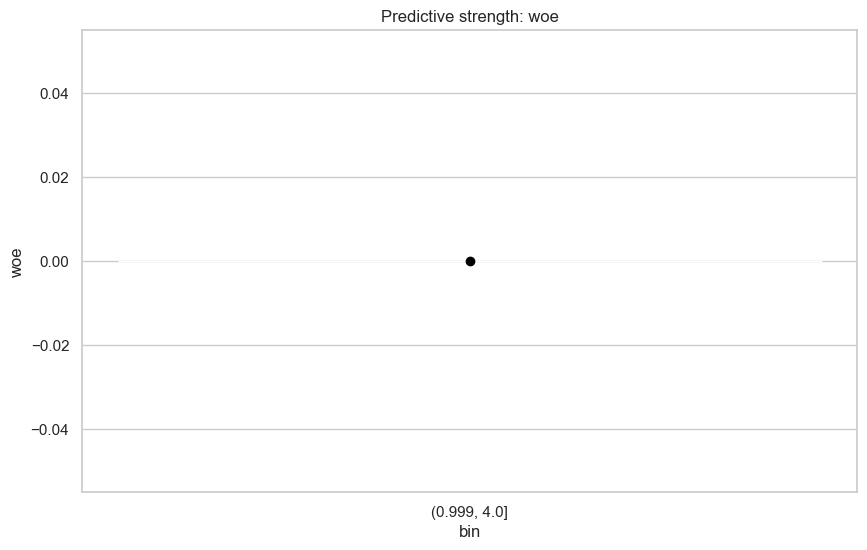

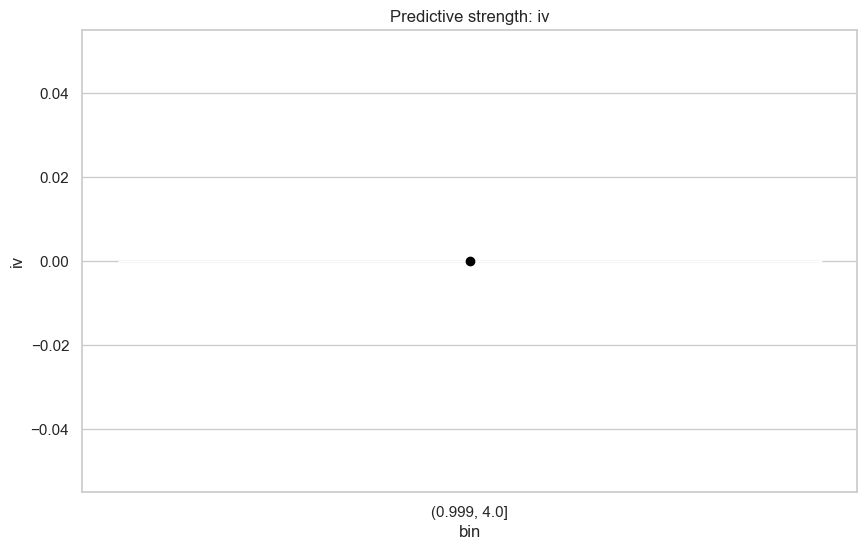

iv=0.0
              woe   iv
bin                   
(0.999, 4.0]  0.0  0.0
Unknown       NaN  NaN




In [6]:

for col in NUMERICAL_COLUMNS:
    num_df = processed_df.copy()
    num_df['bins'] = pd.qcut(num_df[col], q=10, duplicates="drop")

    num_df['bins'] = num_df['bins'].cat.add_categories(['Unknown'])
    num_df.loc[num_df[col].isna(), 'bins'] = 'Unknown'
    

    print(col)
    results, iv = get_measures(
        orig_data=num_df,
        grouped_data=num_df.groupby('bins')
    )
    print(f'{iv=}')
    print(results)
    print("===========================\n\n")


## `optbinning` Library

COLUMN: PURPOSE
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[P],1619814,0.739853,1541080,78734,0.048607,0.145105,0.014610,0.001825
1,[R],146292,0.066819,136357,9935,0.067912,-0.209846,0.003232,0.000403
2,[C],423268,0.193328,389827,33441,0.079007,-0.373139,0.031824,0.003955
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,2189374,1.000000,2067264,122110,0.055774,,0.049667,0.006183


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.10341055
    IV (Jeffrey)             0.04966660
    JS (Jensen-Shannon)      0.00618307
    Hellinger                0.00619566
    Triangular               0.02463252
    KS                       0.10068911
    HHI                      0.58922247
    HHI (normalized)         0.48652809
    Cramer's V               0.05375936
    Quality score            0.10541427

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic       p-value     P[A > B]  P[B > A]
        0      1  1048.667539 4.741821e-230 0.000000e+00       1.0
        1      2   190.199142  2.876490e-43 1.238155e-50       1.0

None


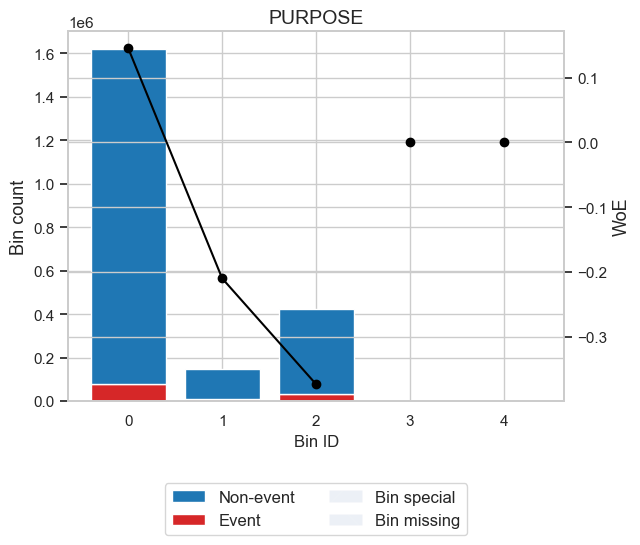


COLUMN: PROP_TYPE
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[CP, PU]",686354,0.313493,651286,35068,0.051093,0.092601,0.002580,0.000322
1,[CO],203017,0.092728,192519,10498,0.051710,0.079951,0.000572,0.000071
2,"[SF, MH]",1300003,0.593778,1223459,76544,0.058880,-0.057487,0.002013,0.000252
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,2189374,1.000000,2067264,122110,0.055774,,0.005165,0.000646


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.03535988
    IV (Jeffrey)             0.00516548
    JS (Jensen-Shannon)      0.00064552
    Hellinger                0.00064560
    Triangular               0.00258139
    KS                       0.03501941
    HHI                      0.45944936
    HHI (normalized)         0.32431170
    Cramer's V               0.01637901
    Quality score            0.01064093

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic      p-value     P[A > B]  P[B > A]
        0      1     1.226173 2.681525e-01 1.347205e-01  0.865279
        1      2   165.456341 7.271502e-38 7.093693e-41  1.000000

None


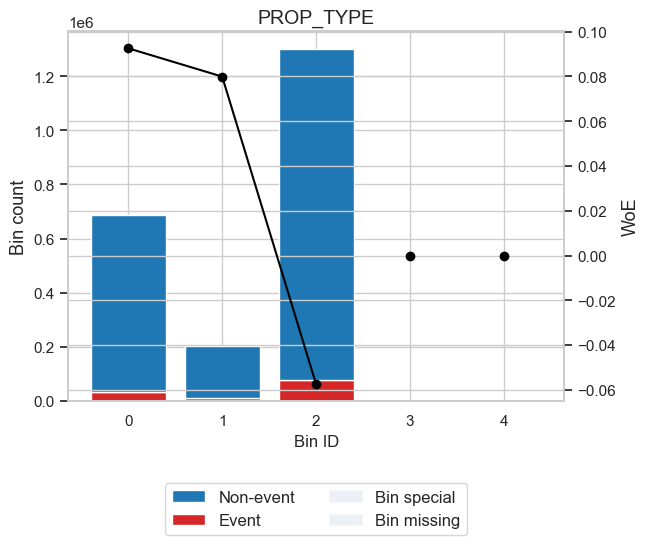


COLUMN: OCC_STAT
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[S, P]",2015124,0.920411,1904772,110352,0.054762,0.019383,0.000343,0.000043
1,[I],174250,0.079589,162492,11758,0.067478,-0.202964,0.003590,0.000448
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,2189374,1.000000,2067264,122110,0.055774,,0.003933,0.000491


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.01768779
    IV (Jeffrey)             0.00393283
    JS (Jensen-Shannon)      0.00049083
    Hellinger                0.00049122
    Triangular               0.00196027
    KS                       0.01768779
    HHI                      0.85349088
    HHI (normalized)         0.80465451
    Cramer's V               0.01499719
    Quality score            0.00320056

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic       p-value  P[A > B]  P[B > A]
        0      1   492.424429 4.229477e-109       0.0       1.0

None


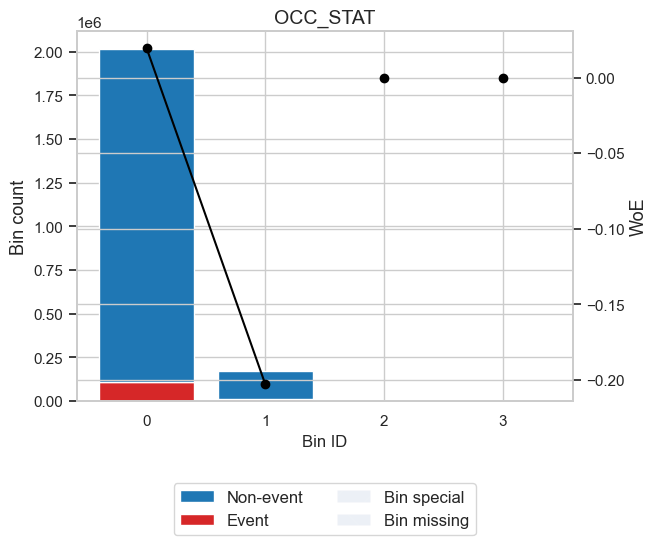


COLUMN: MI_TYPE
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[LPMI, BPMI]",756438,0.345504,715445,40993,0.054192,0.030444,0.000316,0.000039
1,[Unknown],1432936,0.654496,1351819,81117,0.056609,-0.015745,0.000163,0.000020
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,2189374,1.000000,2067264,122110,0.055774,,0.000479,0.000060


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.01037752
    IV (Jeffrey)             0.00047933
    JS (Jensen-Shannon)      0.00005991
    Hellinger                0.00005992
    Triangular               0.00023965
    KS                       0.01037752
    HHI                      0.54773788
    HHI (normalized)         0.39698384
    Cramer's V               0.00500803
    Quality score            0.00120422

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic      p-value     P[A > B]  P[B > A]
        0      1    54.910385 1.261527e-13 1.696761e-15       1.0

None


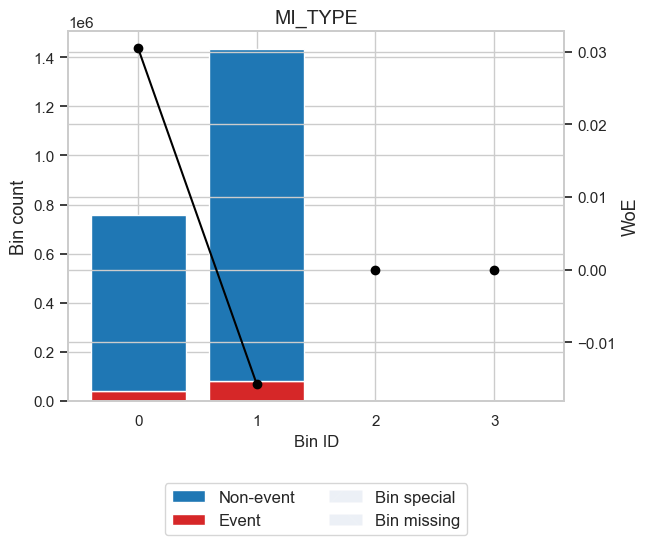


COLUMN: FTHB_FLAG
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[Y],771493,0.352381,736024,35469,0.045974,0.203545,0.013346,0.001665
1,[N],1417881,0.647619,1331240,86641,0.061106,-0.096966,0.006358,0.000794
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,2189374,1.000000,2067264,122110,0.055774,,0.019705,0.002460


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.06557013
    IV (Jeffrey)             0.01970452
    JS (Jensen-Shannon)      0.00245988
    Hellinger                0.00246147
    Triangular               0.00982683
    KS                       0.06557013
    HHI                      0.54358295
    HHI (normalized)         0.39144394
    Cramer's V               0.03149878
    Quality score            0.04989612

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic  p-value  P[A > B]  P[B > A]
        0      1  2172.238037      0.0       0.0       1.0

None


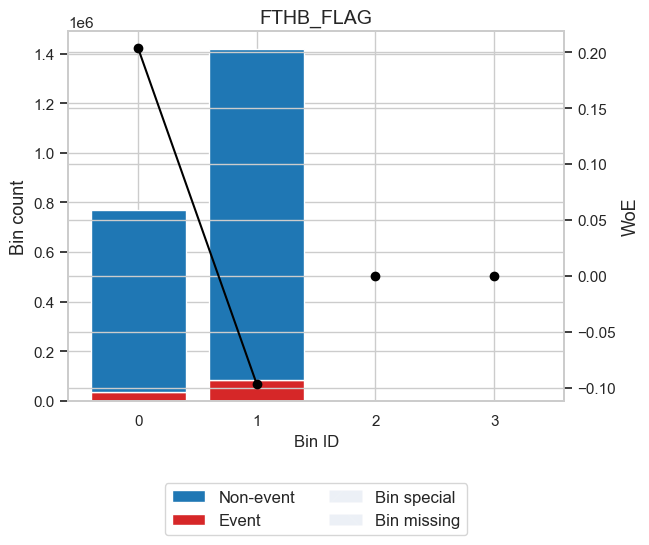

In [7]:
opt_bin_data = processed_df.copy()

for col in CAT_COLUMNS:
    print("====================================================================================================")
    print("COLUMN:", col)
    print("====================================================================================================")
    optb = OptimalBinning(name=col, dtype="categorical", solver="cp")
    optb.fit(processed_df[col], processed_df["DLQ_FLAG"])
    print(optb.status)
    display(optb.binning_table.build())
    print(optb.binning_table.analysis())
    optb.binning_table.plot(metric="woe")
    opt_bin_data[col] = optb.transform(opt_bin_data[col], metric="woe")
    print()


COLUMN: ORIG_RATE
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 3.99)",189131,0.086386,176823,12308,0.065077,-0.164159,2.504999e-03,3.127738e-04
1,"[3.99, 4.36)",117812,0.053811,108806,9006,0.076444,-0.337384,7.125649e-03,8.865055e-04
2,"[4.36, 4.74)",114746,0.052410,105744,9002,0.078452,-0.365485,8.248532e-03,1.025366e-03
3,"[4.74, 4.96)",112500,0.051385,104373,8127,0.072240,-0.27628,4.438787e-03,5.530905e-04
4,"[4.96, 5.74)",437899,0.200011,409600,28299,0.064624,-0.156704,5.267427e-03,6.577555e-04
5,"[5.74, 5.88)",157918,0.072129,148344,9574,0.060626,-0.088576,5.886864e-04,7.356176e-05
6,"[5.88, 6.18)",207855,0.094938,196244,11611,0.055861,-0.001653,2.596432e-07,3.245540e-08
7,"[6.18, 6.62)",341867,0.156148,326606,15261,0.044640,0.234395,7.737852e-03,9.650234e-04
8,"[6.62, 7.12)",277056,0.126546,266277,10779,0.038905,0.377878,1.531677e-02,1.903286e-03
9,"[7.12, inf)",232590,0.106236,224447,8143,0.035010,0.487422,2.041627e-02,2.527067e-03


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.14756395
    IV (Jeffrey)             0.07164523
    JS (Jensen-Shannon)      0.00890446
    Hellinger                0.00892995
    Triangular               0.03541663
    KS                       0.11543186
    HHI                      0.12164782
    HHI (normalized)         0.04179762
    Cramer's V               0.06004692
    Quality score            0.26162999

  Monotonic trend                  peak

  Significance tests

    Bin A  Bin B  t-statistic      p-value     P[A > B]     P[B > A]
        0      1   145.161910 1.979536e-33 5.078679e-59 1.000000e+00
        1      2     3.279945 7.013126e-02 3.470148e-02 9.652985e-01
        2      3    31.447867 2.048675e-08 1.000000e+00 4.018184e-10
        3      4    83.994373 4.961851e-20 1.000000e+00 0.000000e+00
        4      5    31.167595 2.3

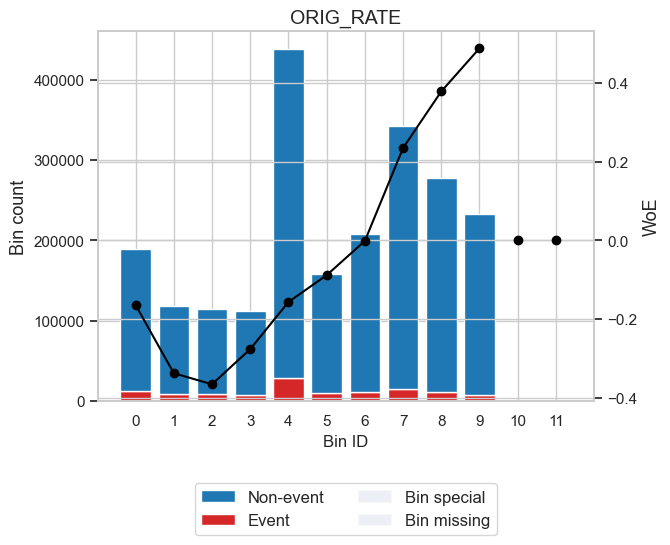


COLUMN: ORIG_AMOUNT
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 124500.00)",235105,0.107385,221100,14005,0.059569,-0.069858,0.000541,6.756295e-05
1,"[124500.00, 172500.00)",250920,0.114608,236611,14309,0.057026,-0.02353,0.000064,8.015158e-06
2,"[172500.00, 199500.00)",139574,0.063751,131721,7853,0.056264,-0.009269,0.000005,6.873963e-07
3,"[199500.00, 249500.00)",292394,0.133551,276278,16116,0.055117,0.012536,0.000021,2.608910e-06
4,"[249500.00, 309500.00)",323398,0.147713,306322,17076,0.052802,0.057904,0.000483,6.033007e-05
5,"[309500.00, 335500.00)",120180,0.054892,113999,6181,0.051431,0.085651,0.000388,4.844816e-05
6,"[335500.00, 360500.00)",110822,0.050618,105092,5730,0.051705,0.080062,0.000313,3.913339e-05
7,"[360500.00, 416500.00)",197456,0.090188,186859,10597,0.053668,0.040724,0.000147,1.836090e-05
8,"[416500.00, 457500.00)",113753,0.051957,107376,6377,0.056060,-0.00542,0.000002,1.912528e-07
9,"[457500.00, 506500.00)",112726,0.051488,106381,6345,0.056287,-0.009699,0.000005,6.080618e-07


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.02962798
    IV (Jeffrey)             0.00272092
    JS (Jensen-Shannon)      0.00034004
    Hellinger                0.00034008
    Triangular               0.00135990
    KS                       0.01105715
    HHI                      0.10536101
    HHI (normalized)         0.03080776
    Cramer's V               0.01197627
    Quality score            0.00025585

  Monotonic trend                valley

  Significance tests

    Bin A  Bin B  t-statistic  p-value  P[A > B]  P[B > A]
        0      1    14.307071 0.000155  0.999953  0.000047
        1      2     0.972995 0.323934  0.838512  0.161488
        2      3     2.370160 0.123674  0.938050  0.061950
        3      4    16.145918 0.000059  0.999984  0.000016
        4      5     3.313153 0.068727  0.966305  0.033695
        5      6     0.0

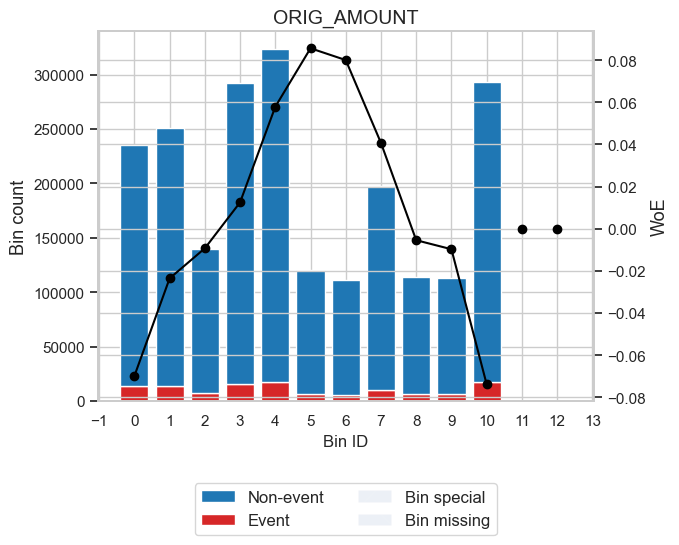


COLUMN: ORIG_TERM
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 239.50)",153912,0.0703,146444,7468,0.048521,0.146957,0.001423,0.000178
1,"[239.50, inf)",2035462,0.9297,1920820,114642,0.056322,-0.010366,0.000100,0.000013
2,Special,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,2189374,1.0000,2067264,122110,0.055774,,0.001523,0.000190


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.00968155
    IV (Jeffrey)             0.00152313
    JS (Jensen-Shannon)      0.00019023
    Hellinger                0.00019031
    Triangular               0.00076029
    KS                       0.00968155
    HHI                      0.86928496
    HHI (normalized)         0.82571328
    Cramer's V               0.00869062
    Quality score            0.00110595

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic      p-value     P[A > B]  P[B > A]
        0      1   165.356657 7.645389e-38 4.055994e-40       1.0

None


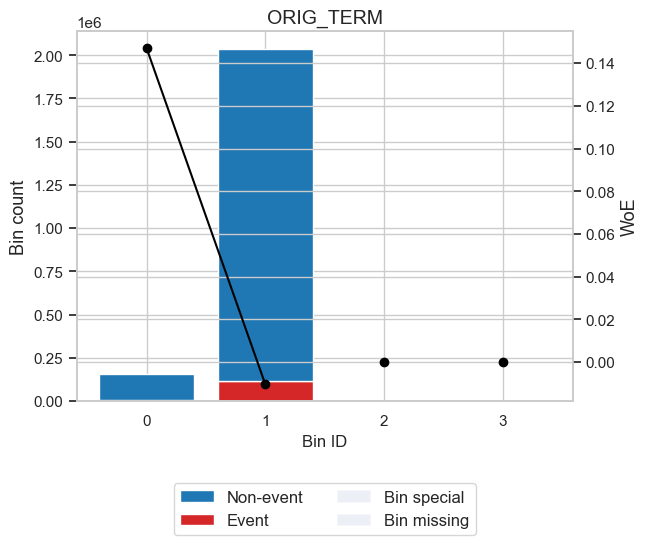


COLUMN: OCLTV
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 41.50)",173119,0.079072,165375,7744,0.044732,0.232238,0.003850,0.000480
1,"[41.50, 50.50)",121591,0.055537,115239,6352,0.052241,0.06918,0.000258,0.000032
2,"[50.50, 57.50)",112054,0.051181,105606,6448,0.057544,-0.033114,0.000057,0.000007
3,"[57.50, 67.50)",215700,0.098521,201661,14039,0.065086,-0.16431,0.002862,0.000357
4,"[67.50, 70.50)",116099,0.053028,107601,8498,0.073196,-0.29046,0.005096,0.000635
5,"[70.50, 79.50)",276125,0.126121,259082,17043,0.061722,-0.107654,0.001534,0.000192
6,"[79.50, 95.50)",1002842,0.458050,949672,53170,0.053019,0.053563,0.001283,0.000160
7,"[95.50, inf)",171844,0.078490,163028,8816,0.051302,0.088295,0.000588,0.000074
8,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
9,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.06475031
    IV (Jeffrey)             0.01552812
    JS (Jensen-Shannon)      0.00193716
    Hellinger                0.00193909
    Triangular               0.00773334
    KS                       0.03062338
    HHI                      0.25635128
    HHI (normalized)         0.17372364
    Cramer's V               0.02911442
    Quality score            0.05323873

  Monotonic trend                  peak

  Significance tests

    Bin A  Bin B  t-statistic      p-value     P[A > B]  P[B > A]
        0      1    88.417654 5.299571e-21 2.727454e-32  1.000000
        1      2    31.668465 1.828676e-08 3.448362e-10  1.000000
        2      3    71.583649 2.657497e-17 4.134958e-20  1.000000
        3      4    78.417663 8.340306e-19 9.293310e-32  1.000000
        4      5   176.757304 2.474385e-40 1.000

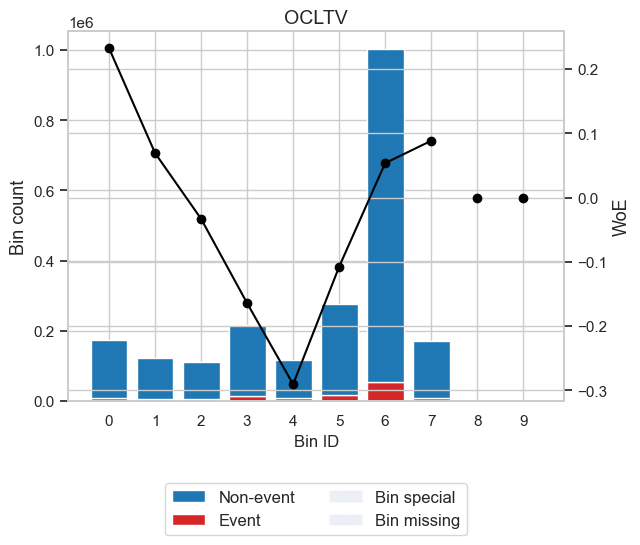


COLUMN: NUM_BO
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",1206543,0.55109,1127828,78715,0.065240,-0.166844,0.016527,0.002064
1,"[1.50, inf)",982831,0.44891,939436,43395,0.044153,0.245876,0.024356,0.003037
2,Special,0,0.00000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.00000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,2189374,1.00000,2067264,122110,0.055774,,0.040883,0.005100


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.09905816
    IV (Jeffrey)             0.04088331
    JS (Jensen-Shannon)      0.00510037
    Hellinger                0.00510539
    Triangular               0.02036156
    KS                       0.09905816
    HHI                      0.50522046
    HHI (normalized)         0.34029394
    Cramer's V               0.04570387
    Quality score            0.11176802

  Monotonic trend            descending

  Significance tests

    Bin A  Bin B  t-statistic  p-value  P[A > B]  P[B > A]
        0      1  4573.261063      0.0       1.0       0.0

None


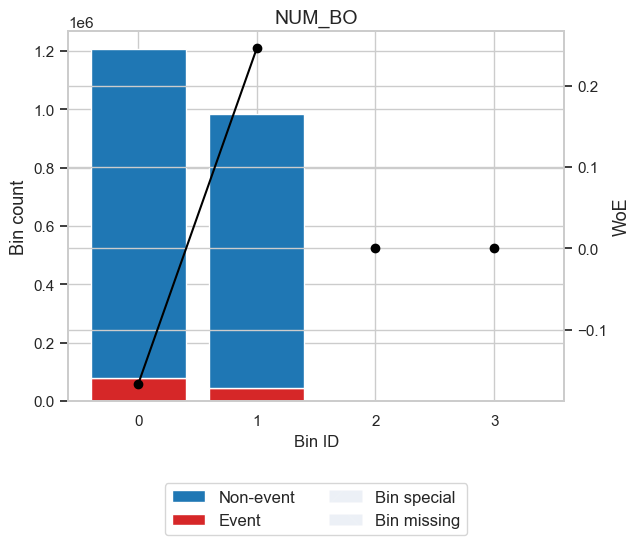


COLUMN: DTI
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 21.50)",155579,0.071061,149434,6145,0.039498,0.362157,0.007954,0.000989
1,"[21.50, 25.50)",135366,0.061829,130002,5364,0.039626,0.358781,0.006802,0.000846
2,"[25.50, 29.50)",189571,0.086587,181342,8229,0.043409,0.263661,0.005360,0.000668
3,"[29.50, 32.50)",175397,0.080113,167233,8164,0.046546,0.190595,0.002676,0.000334
4,"[32.50, 34.50)",131557,0.060089,125080,6477,0.049233,0.131637,0.000982,0.000123
5,"[34.50, 37.50)",221257,0.101059,209498,11759,0.053146,0.051036,0.000257,0.000032
6,"[37.50, 40.50)",250734,0.114523,236225,14509,0.057866,-0.039043,0.000178,0.000022
7,"[40.50, 43.50)",279840,0.127817,262034,17806,0.063629,-0.14012,0.002671,0.000334
8,"[43.50, 48.50)",460312,0.210248,429709,30603,0.066483,-0.187049,0.007997,0.000998
9,"[48.50, inf)",189615,0.086607,176579,13036,0.068750,-0.223005,0.004759,0.000594


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.11025864
    IV (Jeffrey)             0.03971072
    JS (Jensen-Shannon)      0.00494814
    Hellinger                0.00495597
    Triangular               0.01973046
    KS                       0.08779463
    HHI                      0.11776939
    HHI (normalized)         0.03756661
    Cramer's V               0.04473192
    Quality score            0.02223430

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic      p-value     P[A > B]  P[B > A]
        0      1     0.031355 8.594518e-01 4.298815e-01  0.570119
        1      2    28.191212 1.099024e-07 1.156465e-08  1.000000
        2      3    20.902858 4.831733e-06 6.081681e-07  0.999999
        3      4    11.953968 5.453112e-04 1.741393e-04  0.999826
        4      5    25.771148 3.843919e-07 6.809

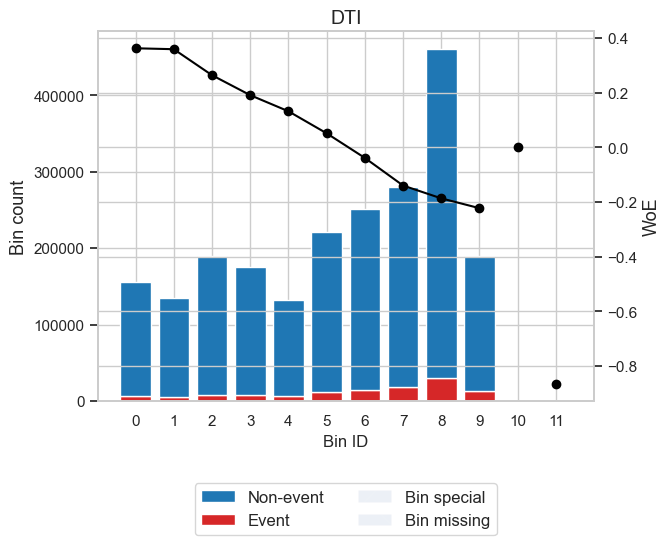


COLUMN: CSCORE_B
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 672.50)",124287,0.056768,102799,21488,0.172890,-1.263778,0.159546,1.871379e-02
1,"[672.50, 692.50)",112925,0.051579,99095,13830,0.122471,-0.85982,0.056166,6.812200e-03
2,"[692.50, 713.50)",176623,0.080673,159727,16896,0.095661,-0.58267,0.035602,4.388391e-03
3,"[713.50, 725.50)",125102,0.057141,115494,9608,0.076801,-0.342436,0.007813,9.718470e-04
4,"[725.50, 736.50)",130347,0.059536,121730,8617,0.066108,-0.180991,0.002114,2.639522e-04
5,"[736.50, 748.50)",170625,0.077933,161170,9455,0.055414,0.006857,0.000004,4.566454e-07
6,"[748.50, 758.50)",161430,0.073733,153778,7652,0.047401,0.171484,0.002010,2.509680e-04
7,"[758.50, 767.50)",161922,0.073958,155146,6776,0.041847,0.301921,0.005905,7.353298e-04
8,"[767.50, 774.50)",134273,0.061329,129402,4871,0.036277,0.450566,0.010230,1.268082e-03
9,"[774.50, 784.50)",211903,0.096787,204997,6906,0.032590,0.561546,0.023926,2.952097e-03


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.38085660
    IV (Jeffrey)             0.47636109
    JS (Jensen-Shannon)      0.05724453
    Hellinger                0.05836102
    Triangular               0.22077009
    KS                       0.28716876
    HHI                      0.06881332
    HHI (normalized)         0.01061415
    Cramer's V               0.17369971
    Quality score            0.68619804

  Monotonic trend            descending

  Significance tests

    Bin A  Bin B  t-statistic       p-value  P[A > B]     P[B > A]
        0      1  1186.943371 4.196448e-260  1.000000 0.000000e+00
        1      2   521.940748 1.600693e-115  1.000000 0.000000e+00
        2      3   325.098907  1.122731e-72  1.000000 0.000000e+00
        3      4   110.168262  9.001634e-26  1.000000 0.000000e+00
        4      5   149.737413  1.978587e-34

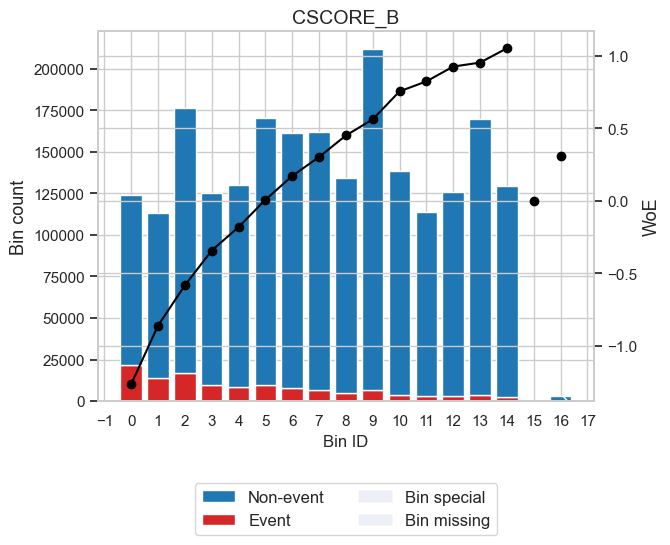


COLUMN: CSCORE_C
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 676.50)",134902,0.061617,113174,21728,0.161065,-1.178734,0.145211,0.017169
1,"[676.50, 695.50)",113956,0.052050,100646,13310,0.116799,-0.805965,0.048611,0.005917
2,"[695.50, 713.50)",154280,0.070468,139814,14466,0.093765,-0.560547,0.028495,0.003516
3,"[713.50, 725.50)",124935,0.057064,115455,9480,0.075879,-0.329362,0.007175,0.000893
4,"[725.50, 736.50)",130141,0.059442,121448,8693,0.066797,-0.192091,0.002390,0.000298
5,"[736.50, 744.50)",112119,0.051211,105721,6398,0.057064,-0.024241,0.000030,0.000004
6,"[744.50, 753.50)",137247,0.062688,130091,7156,0.052140,0.071224,0.000308,0.000039
7,"[753.50, 760.50)",120211,0.054907,114712,5499,0.045745,0.208799,0.002183,0.000272
8,"[760.50, 767.50)",125247,0.057207,119964,5283,0.042181,0.293639,0.004336,0.000540
9,"[767.50, 774.50)",133422,0.060941,128318,5104,0.038255,0.395428,0.008017,0.000996


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.35583097
    IV (Jeffrey)             0.41358949
    JS (Jensen-Shannon)      0.04997060
    Hellinger                0.05081246
    Triangular               0.19362876
    KS                       0.26982349
    HHI                      0.07064931
    HHI (normalized)         0.01256489
    Cramer's V               0.16167029
    Quality score            0.93362031

  Monotonic trend            descending

  Significance tests

    Bin A  Bin B  t-statistic       p-value  P[A > B]     P[B > A]
        0      1  1000.581174 1.342579e-219  1.000000 0.000000e+00
        1      2   374.647941  1.820581e-83  1.000000 0.000000e+00
        2      3   281.634255  3.307252e-63  1.000000 0.000000e+00
        3      4    79.469093  4.898283e-19  1.000000 0.000000e+00
        4      5    97.667266  4.949372e-23

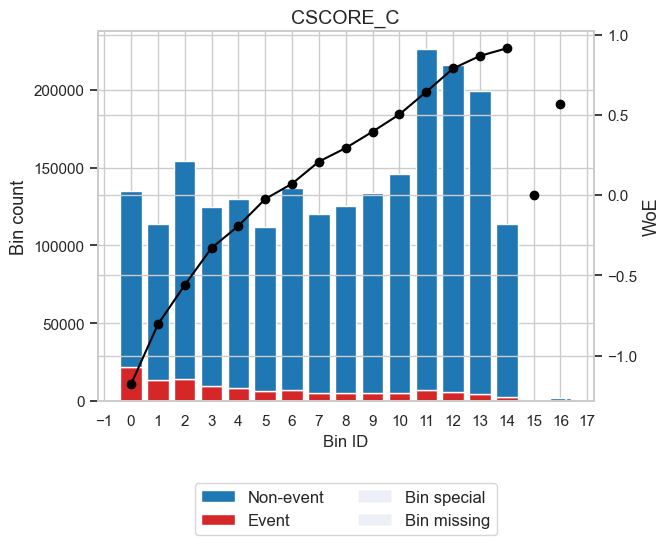


COLUMN: NUM_UNIT
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",2189374,1.0,2067264,122110,0.055774,0.0,0.0,0.0
1,Special,0,0.0,0,0,0.000000,0.0,0.0,0.0
2,Missing,0,0.0,0,0,0.000000,0.0,0.0,0.0
Totals,,2189374,1.0,2067264,122110,0.055774,,0.0,0.0


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.00000000
    IV (Jeffrey)             0.00000000
    JS (Jensen-Shannon)      0.00000000
    Hellinger                0.00000000
    Triangular               0.00000000
    KS                       0.00000000
    HHI                      1.00000000
    HHI (normalized)         1.00000000
    Cramer's V               0.00000000
    Quality score            0.00000000

  Monotonic trend             undefined

  Significance tests

    None

None


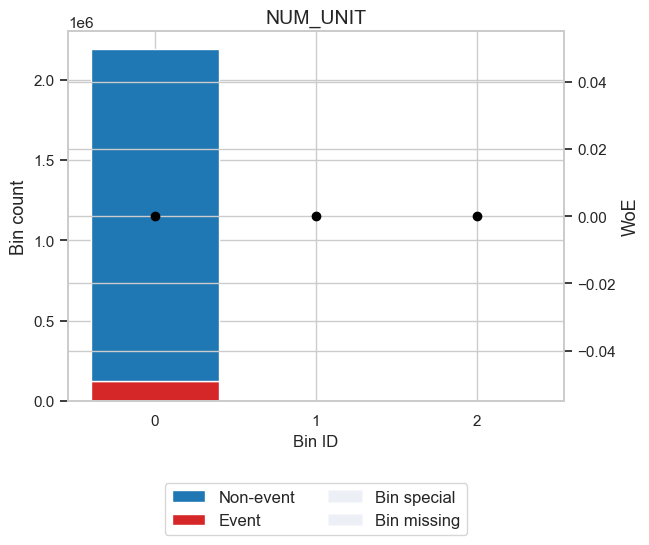

In [8]:

for col in NUMERICAL_COLUMNS:
    print("====================================================================================================")
    print("COLUMN:", col)
    print("====================================================================================================")
    optb = OptimalBinning(name=col, dtype="numerical", solver="cp")
    optb.fit(processed_df[col], processed_df["DLQ_FLAG"])
    print(optb.status)
    display(optb.binning_table.build())
    print(optb.binning_table.analysis())
    optb.binning_table.plot(metric="woe")
    opt_bin_data[col] = optb.transform(processed_df[col], metric="woe")
    print()

# Model fitting

In [9]:
opt_bin_data["ORIG_DTE_YR"] = pd.to_datetime(opt_bin_data["ORIG_DTE"]).dt.year - 2000
opt_bin_data["ORIG_DTE_MONTH"] = pd.to_datetime(opt_bin_data["ORIG_DTE"]).dt.month
opt_bin_data["FRST_DTE_YR"] = pd.to_datetime(opt_bin_data["FRST_DTE"]).dt.year - 2000
opt_bin_data["FRST_DTE_MONTH"] = pd.to_datetime(opt_bin_data["FRST_DTE"]).dt.month
opt_bin_data.drop(columns=["ORIG_DTE","FRST_DTE","AQSN_DTE"],inplace=True)

opt_bin_data

,LOAN_ID,ORIG_RATE,ORIG_AMOUNT,ORIG_TERM,OCLTV,NUM_BO,DTI,CSCORE_B,CSCORE_C,FTHB_FLAG,...,PROP_TYPE,NUM_UNIT,OCC_STAT,MI_PCT,MI_TYPE,DLQ_FLAG,ORIG_DTE_YR,ORIG_DTE_MONTH,FRST_DTE_YR,FRST_DTE_MONTH
0,135176712,0.234395,0.012536,-0.010366,-0.164310,-0.166844,0.051036,0.925424,0.788982,-0.096966,...,0.092601,0.0,-0.202964,0.0,-0.015745,0,23,1,23,3
1,135176713,0.234395,-0.023530,-0.010366,0.069180,-0.166844,-0.140120,0.006857,0.071224,-0.096966,...,-0.057487,0.0,0.019383,0.0,-0.015745,0,22,12,23,2
2,135176714,0.487422,0.012536,-0.010366,-0.107654,0.245876,0.263661,0.925424,0.867392,-0.096966,...,0.092601,0.0,-0.202964,0.0,-0.015745,0,22,12,23,2
3,135176715,0.377878,0.040724,-0.010366,0.053563,-0.166844,-0.187049,0.754549,0.643629,0.203545,...,-0.057487,0.0,0.019383,12.0,0.030444,0,22,12,23,2
4,135176716,0.377878,0.080062,-0.010366,0.069180,0.245876,0.051036,-1.263778,-1.178734,-0.096966,...,-0.057487,0.0,0.019383,0.0,-0.015745,1,22,12,23,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2189369,137429687,-0.365485,0.040724,-0.010366,0.053563,0.245876,0.051036,0.006857,0.395428,0.203545,...,0.092601,0.0,0.019383,0.0,-0.015745,0,23,11,24,1
2189370,137429688,0.377878,-0.023530,-0.010366,-0.290460,-0.166844,0.190595,0.952798,0.867392,0.203545,...,-0.057487,0.0,0.019383,0.0,-0.015745,0,23,11,24,1
2189371,137429689,0.487422,-0.073781,-0.010366,-0.164310,-0.166844,-0.223005,0.925424,0.788982,-0.096966,...,-0.057487,0.0,0.019383,0.0,-0.015745,0,23,10,23,12
2189372,137429690,0.487422,0.085651,-0.010366,0.088295,0.245876,-0.187049,-0.342436,-0.192091,0.203545,...,-0.057487,0.0,0.019383,35.0,0.030444,0,23,11,24,1


In [10]:
opt_bin_data.columns

Index(['LOAN_ID', 'ORIG_RATE', 'ORIG_AMOUNT', 'ORIG_TERM', 'OCLTV', 'NUM_BO',
       'DTI', 'CSCORE_B', 'CSCORE_C', 'FTHB_FLAG', 'PURPOSE', 'PROP_TYPE',
       'NUM_UNIT', 'OCC_STAT', 'MI_PCT', 'MI_TYPE', 'DLQ_FLAG', 'ORIG_DTE_YR',
       'ORIG_DTE_MONTH', 'FRST_DTE_YR', 'FRST_DTE_MONTH'],
      dtype='object')

In [17]:
X, Y = opt_bin_data.drop(columns=["DLQ_FLAG", "LOAN_ID"]), opt_bin_data["DLQ_FLAG"]
train_split = 0.7
X_train, X_test = X[:int(train_split*len(X))], X[int(train_split*len(X)):]
Y_train, Y_test = Y[:int(train_split*len(X))], Y[int(train_split*len(X)):]


In [18]:
def fit_logistic_regression(
    train: list[pd.DataFrame, pd.DataFrame],
    test: list[pd.DataFrame, pd.DataFrame],
    model_config: dict = {}
):
    logistic_model = linear_model.LogisticRegression(
        C = model_config.get("C", 1),
        solver=model_config.get("solver", "liblinear"),
        random_state=model_config.get("random_state", 0),
        class_weight=model_config.get("class_weight", None)
    )
    logistic_model.fit(train[0], train[1])

    print("Training accuracy:", logistic_model.score(train[0], train[1]))
    print("Testing accuracy:", logistic_model.score(test[0], test[1]))
    print(
        classification_report(
            y_pred=logistic_model.predict(test[0]),
            y_true=test[1]
        )
    )
    # Training AUC
    fpr, tpr, thresholds = metrics.roc_curve(train[1], logistic_model.predict(train[0]), pos_label=1)
    print("Training AUC:", metrics.auc(fpr, tpr))

    # Testing AUC
    fpr, tpr, thresholds = metrics.roc_curve(test[1], logistic_model.predict(test[0]), pos_label=1)
    print("Testing AUC:", metrics.auc(fpr, tpr))
    return logistic_model

In [19]:
woe_model = fit_logistic_regression(
    [X_train, Y_train],
    [X_test, Y_test]
)

Training accuracy: 0.930799491830994
Testing accuracy: 0.9755546860369694


/Users/melina/Documents/Uni/Fall 2024/MIE479/msf-capstone-crm/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/melina/Documents/Uni/Fall 2024/MIE479/msf-capstone-crm/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/melina/Documents/Uni/Fall 2024/MIE479/msf-capstone-crm/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    640757
           1       0.00      0.00      0.00     16056

    accuracy                           0.98    656813
   macro avg       0.49      0.50      0.49    656813
weighted avg       0.95      0.98      0.96    656813

Training AUC: 0.5
Testing AUC: 0.5


In [20]:
woe_model = fit_logistic_regression(
    [X_train, Y_train],
    [X_test, Y_test],
    model_config={
        "class_weight": {
            0 :  len(Y_train)/(2*(len(Y_train)-sum(Y_train))),
            1 :  len(Y_train)/(2* sum(Y_train))
        }
    }
)

Training accuracy: 0.6638985332394599
Testing accuracy: 0.904213223550691
              precision    recall  f1-score   support

           0       0.98      0.92      0.95    640757
           1       0.08      0.26      0.12     16056

    accuracy                           0.90    656813
   macro avg       0.53      0.59      0.53    656813
weighted avg       0.96      0.90      0.93    656813

Training AUC: 0.6592765653134359
Testing AUC: 0.5900698305415639


In [21]:
oversample = SMOTE()
X_train_smote, Y_train_smote = oversample.fit_resample(X_train, Y_train)
complete_model = fit_logistic_regression(
    [X_train_smote, Y_train_smote],
    [X_test, Y_test],
    # model_config={"C" : 100,}
)

Training accuracy: 0.6615407425270258
Testing accuracy: 0.9063325482291003
              precision    recall  f1-score   support

           0       0.98      0.92      0.95    640757
           1       0.08      0.25      0.12     16056

    accuracy                           0.91    656813
   macro avg       0.53      0.59      0.53    656813
weighted avg       0.96      0.91      0.93    656813

Training AUC: 0.6615407425270259
Testing AUC: 0.5879074530506412


In [22]:
woe_model = fit_logistic_regression(
    [pd.DataFrame(X_train["CSCORE_B"]), Y_train],
    [pd.DataFrame(X_test["CSCORE_B"]), Y_test],
        model_config={
        "class_weight":"balanced"}
)

Training accuracy: 0.6863576718969098
Testing accuracy: 0.7414180291802994
              precision    recall  f1-score   support

           0       0.98      0.75      0.85    640757
           1       0.05      0.50      0.09     16056

    accuracy                           0.74    656813
   macro avg       0.52      0.62      0.47    656813
weighted avg       0.96      0.74      0.83    656813

Training AUC: 0.6411590718088876
Testing AUC: 0.6230354287016606


In [23]:
no_date_train = X_train.drop(columns=["ORIG_DTE_YR","ORIG_DTE_MONTH", "FRST_DTE_YR", "FRST_DTE_MONTH"])
no_date_test = X_test.drop(columns=["ORIG_DTE_YR","ORIG_DTE_MONTH", "FRST_DTE_YR", "FRST_DTE_MONTH"])
woe_model = fit_logistic_regression(
    [no_date_train, Y_train],
    [no_date_test, Y_test],
    model_config={
        "class_weight": "balanced"
    }
)

Training accuracy: 0.6619371104967436
Testing accuracy: 0.7781727828164181
              precision    recall  f1-score   support

           0       0.98      0.79      0.87    640757
           1       0.05      0.47      0.09     16056

    accuracy                           0.78    656813
   macro avg       0.52      0.63      0.48    656813
weighted avg       0.96      0.78      0.85    656813

Training AUC: 0.6542385442129686
Testing AUC: 0.6299111955717326
